# Here we're going to take Final Fantasy MIDIs and convert them to 2D images with multiple channels
- the x information will be the offset of the note
- the y information will be the pitch of the note
- the channels will stack multiple 'measures' consecutively, so you have longer time domain info considered
- since we'll be training a GAN we don't need validation info

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential
import math

from music21 import converter, instrument, note, chord, stream
import glob

from keras.utils import np_utils
import os

FONTSIZE=24
plt.rcParams['figure.figsize']=(16,9)
plt.rcParams['font.size']=FONTSIZE

# First let's rename all of our Final Fantasy MIDIs to get rid of annoying spaces

In [8]:
filenames=glob.glob('../MIDI_Files/F/F/Final Fantasy*.mid')
print(len(filenames))

for i in filenames:
    fbase=i[18:]
    fnew=fbase.replace(" ","")
    
    command='cp "'+str(i)+'" ../Final_Fantasy/'+fnew
    print(command)
    os.system(command)

218
cp "../MIDI_Files/F/F/Final Fantasy V - Clash on the Big Bridge Battle with Gilgamesh.mid" ../Final_Fantasy/FinalFantasyV-ClashontheBigBridgeBattlewithGilgamesh.mid
cp "../MIDI_Files/F/F/Final Fantasy II - Battle 1.mid" ../Final_Fantasy/FinalFantasyII-Battle1.mid
cp "../MIDI_Files/F/F/Final Fantasy VII - Battle Theme.mid" ../Final_Fantasy/FinalFantasyVII-BattleTheme.mid
cp "../MIDI_Files/F/F/Final Fantasy II - Battle 2.mid" ../Final_Fantasy/FinalFantasyII-Battle2.mid
cp "../MIDI_Files/F/F/Final Fantasy X - Thunder Plateau.mid" ../Final_Fantasy/FinalFantasyX-ThunderPlateau.mid
cp "../MIDI_Files/F/F/Final Fantasy VI - Awakening.mid" ../Final_Fantasy/FinalFantasyVI-Awakening.mid
cp "../MIDI_Files/F/F/Final Fantasy VII - OneWinged Angel.mid" ../Final_Fantasy/FinalFantasyVII-OneWingedAngel.mid
cp "../MIDI_Files/F/F/Final Fantasy VII - Still More Fighting.mid" ../Final_Fantasy/FinalFantasyVII-StillMoreFighting.mid
cp "../MIDI_Files/F/F/Final Fantasy III - Boundless Ocean.mid" ../Final_Fa

cp "../MIDI_Files/F/F/Final Fantasy VII - Cosmo Canyon.mid" ../Final_Fantasy/FinalFantasyVII-CosmoCanyon.mid
cp "../MIDI_Files/F/F/Final Fantasy I - Final Fantasy.mid" ../Final_Fantasy/FinalFantasyI-FinalFantasy.mid
cp "../MIDI_Files/F/F/Final Fantasy VIII - FITHOS LUSEC WECOS VINOSEC.mid" ../Final_Fantasy/FinalFantasyVIII-FITHOSLUSECWECOSVINOSEC.mid
cp "../MIDI_Files/F/F/Final Fantasy III - Crystal Tower.mid" ../Final_Fantasy/FinalFantasyIII-CrystalTower.mid
cp "../MIDI_Files/F/F/Final Fantasy VI - Slam Shuffle.mid" ../Final_Fantasy/FinalFantasyVI-SlamShuffle.mid
cp "../MIDI_Files/F/F/Final Fantasy VIII - Waltz for the moon.mid" ../Final_Fantasy/FinalFantasyVIII-Waltzforthemoon.mid
cp "../MIDI_Files/F/F/Final Fantasy VII-Crisis Core - Melody of Agony.mid" ../Final_Fantasy/FinalFantasyVII-CrisisCore-MelodyofAgony.mid
cp "../MIDI_Files/F/F/Final Fantasy Crystal Chronicles - Departure.mid" ../Final_Fantasy/FinalFantasyCrystalChronicles-Departure.mid
cp "../MIDI_Files/F/F/Final Fantasy VI

cp "../MIDI_Files/F/F/Final Fantasy I - Sailing Ship.mid" ../Final_Fantasy/FinalFantasyI-SailingShip.mid
cp "../MIDI_Files/F/F/Final Fantasy VIII - Julia's Piano Solo.mid" ../Final_Fantasy/FinalFantasyVIII-Julia'sPianoSolo.mid
cp "../MIDI_Files/F/F/Final Fantasy IX - Youre Not Alone.mid" ../Final_Fantasy/FinalFantasyIX-YoureNotAlone.mid
cp "../MIDI_Files/F/F/Final Fantasy VII-Crisis Core - Crisis core title.mid" ../Final_Fantasy/FinalFantasyVII-CrisisCore-Crisiscoretitle.mid
cp "../MIDI_Files/F/F/Final Fantasy III - Jinn the Fire.mid" ../Final_Fantasy/FinalFantasyIII-JinntheFire.mid
cp "../MIDI_Files/F/F/Final Fantasy IX - Eternal Harvest (really fun to play! ^__^).mid" ../Final_Fantasy/FinalFantasyIX-EternalHarvest(reallyfuntoplay!^__^).mid
cp "../MIDI_Files/F/F/Final Fantasy II - Battle 3.mid" ../Final_Fantasy/FinalFantasyII-Battle3.mid
cp "../MIDI_Files/F/F/Final Fantasy III - Ancients Village.mid" ../Final_Fantasy/FinalFantasyIII-AncientsVillage.mid
cp "../MIDI_Files/F/F/Final Fant

# Visualize the MIDI information

In [9]:
filename='../Final_Fantasy/FinalFantasyCrystalChronicles-AnnualFestival.mid'
midi=converter.parse(filename)
s2=instrument.partitionByInstrument(midi)

pitches=[]
offsets=[]
durations=[]

for part in s2.parts:
    if 'Piano' in str(part):
        notes_to_parse=part.recurse()
        for element in notes_to_parse:
            
            if isinstance(element,note.Note):
                offsets.append(element.offset)
                pitches.append(element.nameWithOctave)
                durations.append(element.duration.quarterLength)

            elif isinstance(element,chord.Chord):
                
                for pitch in element.pitches:
                    offsets.append(element.offset)
                    pitches.append(pitch.nameWithOctave)
                    durations.append(element.duration.quarterLength)
                    
                    
                
print(max(offsets))
print(len(offsets))
print(len(pitches))
print(len(durations))

244.0
983
983
983


In [10]:
print(set(durations))

{0.5, 1.5, 0.0, 0.25, 1.0, 4.0, 2.0, 7.0, 6.0, Fraction(1, 3)}


In [11]:

print(float(durations[119]))

0.3333333333333333


In [12]:
print(set(pitches))

{'A3', 'D5', 'B2', 'B-3', 'C#4', 'D2', 'B4', 'E5', 'A4', 'C5', 'E-3', 'F#4', 'G4', 'C#3', 'D3', 'C#5', 'F#5', 'A2', 'F#3', 'E-5', 'D4', 'A5', 'C2', 'G5', 'B-2', 'E4', 'G2', 'E-4', 'C4', 'G3', 'E3', 'B3', 'C3'}


# Create a dictionary that maps all pitches to ints, keeping their order

In [13]:
#this will have key=pitch value=integer

pitch_dict={}

min_octave=-5
num_octaves=11

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        

num_pitches=count+1
print(num_pitches)
    

132


# Fill out grid locations

In [14]:
pixel_length=float(1/12) #this is divisible by both 1/3 and 1/4


grid_all=np.zeros((num_pitches,int(max(offsets)/pixel_length)))

for i in range(len(offsets)):
    
    
    offset_temp=offsets[i]
    pitch_temp=pitches[i]
    duration_temp=durations[i]


    #find column grid value
    column_start_idx=int(offset_temp/pixel_length-1)
    column_end_idx=int(column_start_idx+duration_temp/pixel_length)

    #find row grid value
    row_idx=int(pitch_dict[pitch_temp])

    grid_all[row_idx,column_start_idx:column_end_idx]=1

In [15]:
print(grid_all.shape)

(132, 2928)


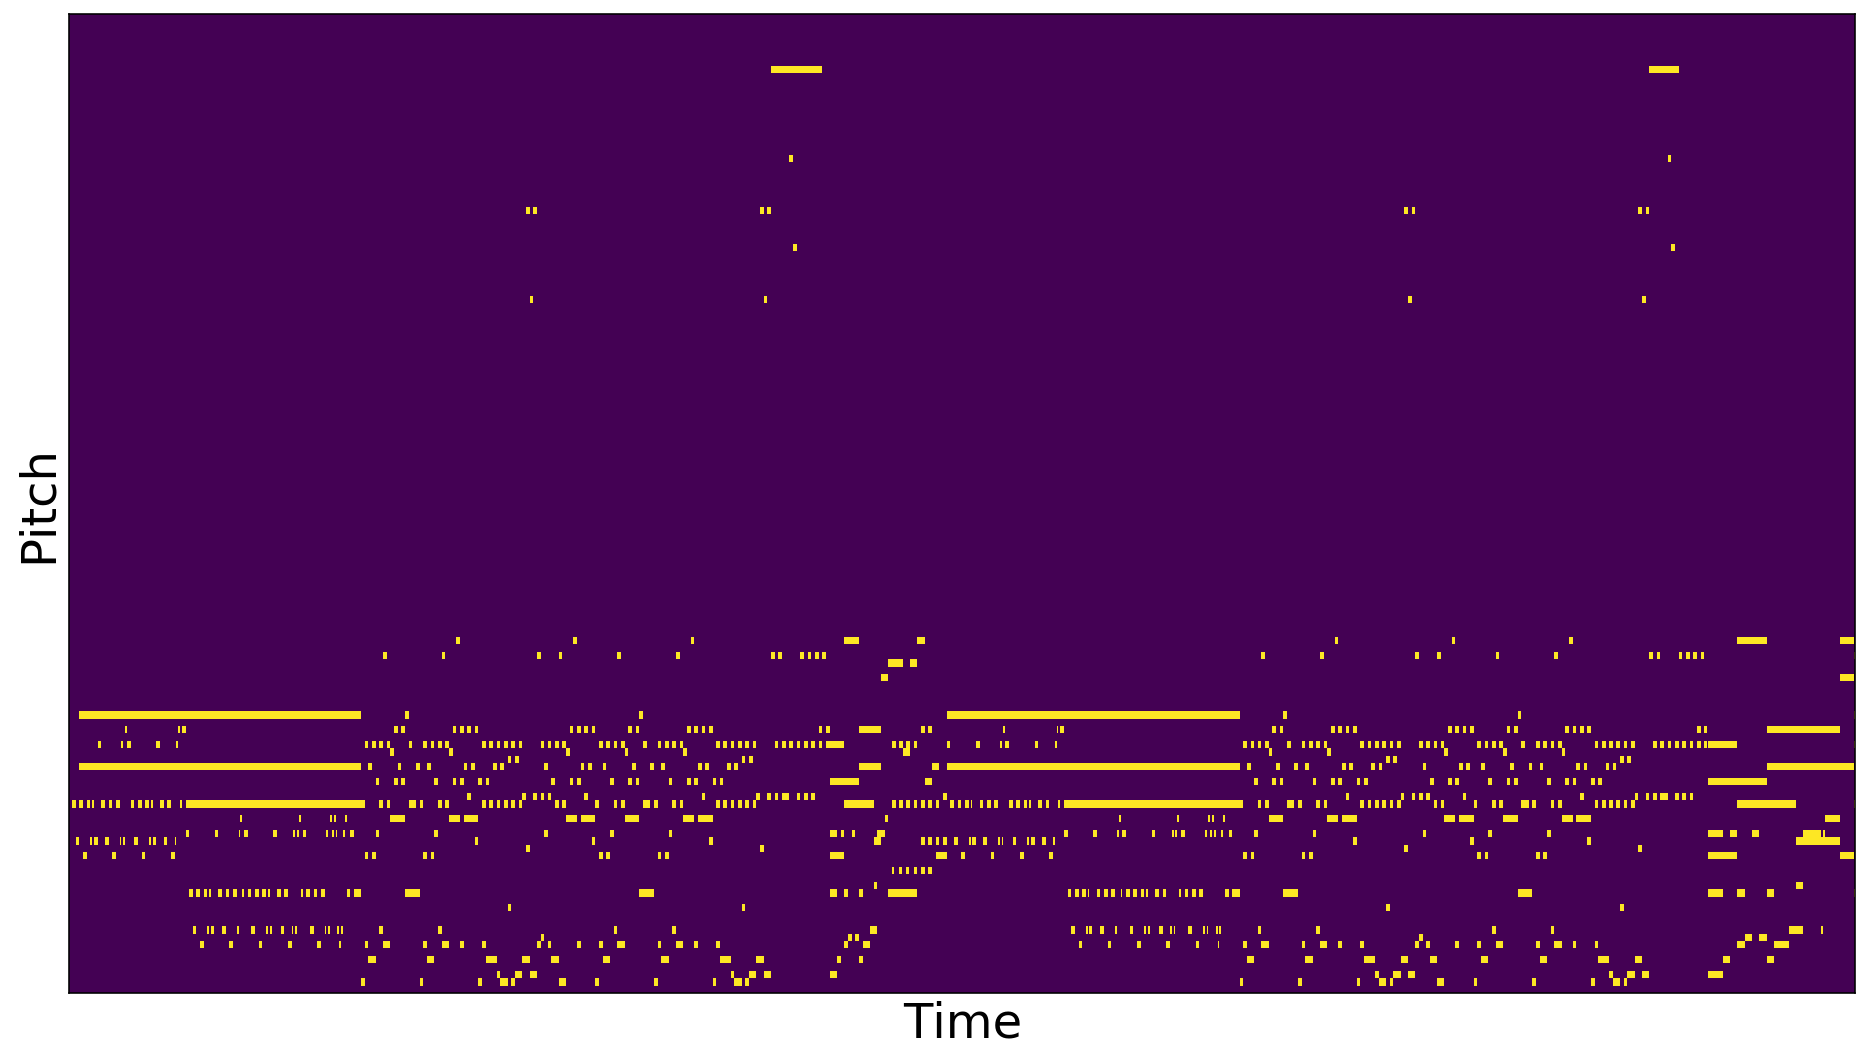

In [18]:

#plt.axis([0,grid_all.shape[1],0,grid_all.shape[0]])
plt.imshow(grid_all,extent=[-10,10,-1,1],aspect='auto')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.xticks(ticks=[],labels=[])
plt.yticks(ticks=[],labels=[])
plt.savefig('./plots/image_plot.png',bbox_inches='tight')
#plt.axis('off')

# Ok now that we know this works for one song let's do it for every song

at the end of the day we'll have a list where each element is our 2D grid for a given song

In [19]:
# Let's figure out our whole range of notes

filenames=glob.glob('../Final_Fantasy/FinalFantasy*.mid')

pitches=[]
offsets=[]
durations=[]

skip_song_idx=[]
count=-1
for i in filenames:
    count+=1
    try:
    
        filename=i
        midi=converter.parse(filename)
        s2=instrument.partitionByInstrument(midi)

        for part in s2.parts:
            if 'Piano' in str(part):
                notes_to_parse=part.recurse()
                for element in notes_to_parse:

                    if isinstance(element,note.Note):
                        offsets.append(element.offset)
                        pitches.append(element.nameWithOctave)
                        durations.append(element.duration.quarterLength)

                    elif isinstance(element,chord.Chord):

                        for pitch in element.pitches:
                            offsets.append(element.offset)
                            pitches.append(pitch.nameWithOctave)
                            durations.append(element.duration.quarterLength)
                                
    except:
        skip_song_idx.append(count)
        
idx_all=np.arange(len(filenames))
idx_keep=np.delete(idx_all,skip_song_idx)
                
print(max(offsets))
print(len(offsets))
print(len(pitches))
print(len(durations))

2607.0
136959
136959
136959


In [20]:
print(len(idx_keep))
print(len(skip_song_idx))

187
5


In [21]:
print(set(pitches))

{'G#6', 'B2', 'D6', 'B-3', 'G#5', 'G#1', 'C#7', 'B-1', 'C#5', 'F1', 'F#5', 'F#3', 'E4', 'G5', 'G3', 'A1', 'B3', 'D7', 'B4', 'E1', 'C7', 'C5', 'G4', 'A2', 'E6', 'E-5', 'B0', 'C#2', 'G2', 'C6', 'B-5', 'G#4', 'D5', 'D2', 'F3', 'E5', 'A4', 'F2', 'F#4', 'E-3', 'F5', 'B-4', 'C1', 'B1', 'B-6', 'C#3', 'B5', 'G#2', 'D4', 'A5', 'C2', 'E-6', 'B-2', 'E2', 'E-4', 'F6', 'G7', 'A6', 'A3', 'F#6', 'G1', 'C#4', 'E-1', 'E7', 'G6', 'F#1', 'D3', 'F#2', 'F4', 'E-2', 'C4', 'D1', 'G#3', 'B6', 'E3', 'C3', 'C#6'}


In [22]:
lengths=[len(i) for i in pitches]
print(set(lengths))

{2, 3}


In [23]:
print(set(durations))

{0.0, 0.5, 2.0, 3.0, 1.5, 4.0, 3.75, 1.0, 0.25, 0.75, 1.75, 5.0, 7.0, 8.0, 2.5, 9.0, 3.5, 2.25, 2.75, 11.75, 12.0, 4.5, 4.75, 3.25, 15.0, 4.25, 5.75, 5.5, 6.0, 6.25, 1.25, 6.75, 6.5, 7.25, 7.5, 7.75, 40.0, Fraction(2, 3), Fraction(5, 3), Fraction(8, 3), Fraction(11, 3), 9.5, 9.75, 10.0, 10.5, 11.5, 11.25, 11.0, 12.25, 16.0, Fraction(1, 3), Fraction(4, 3), Fraction(7, 3), Fraction(10, 3), Fraction(13, 3), Fraction(22, 3)}


In [24]:
print(max(offsets))

2607.0


In [25]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

pitch_dict={}

min_octave=-6
num_octaves=14

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

168


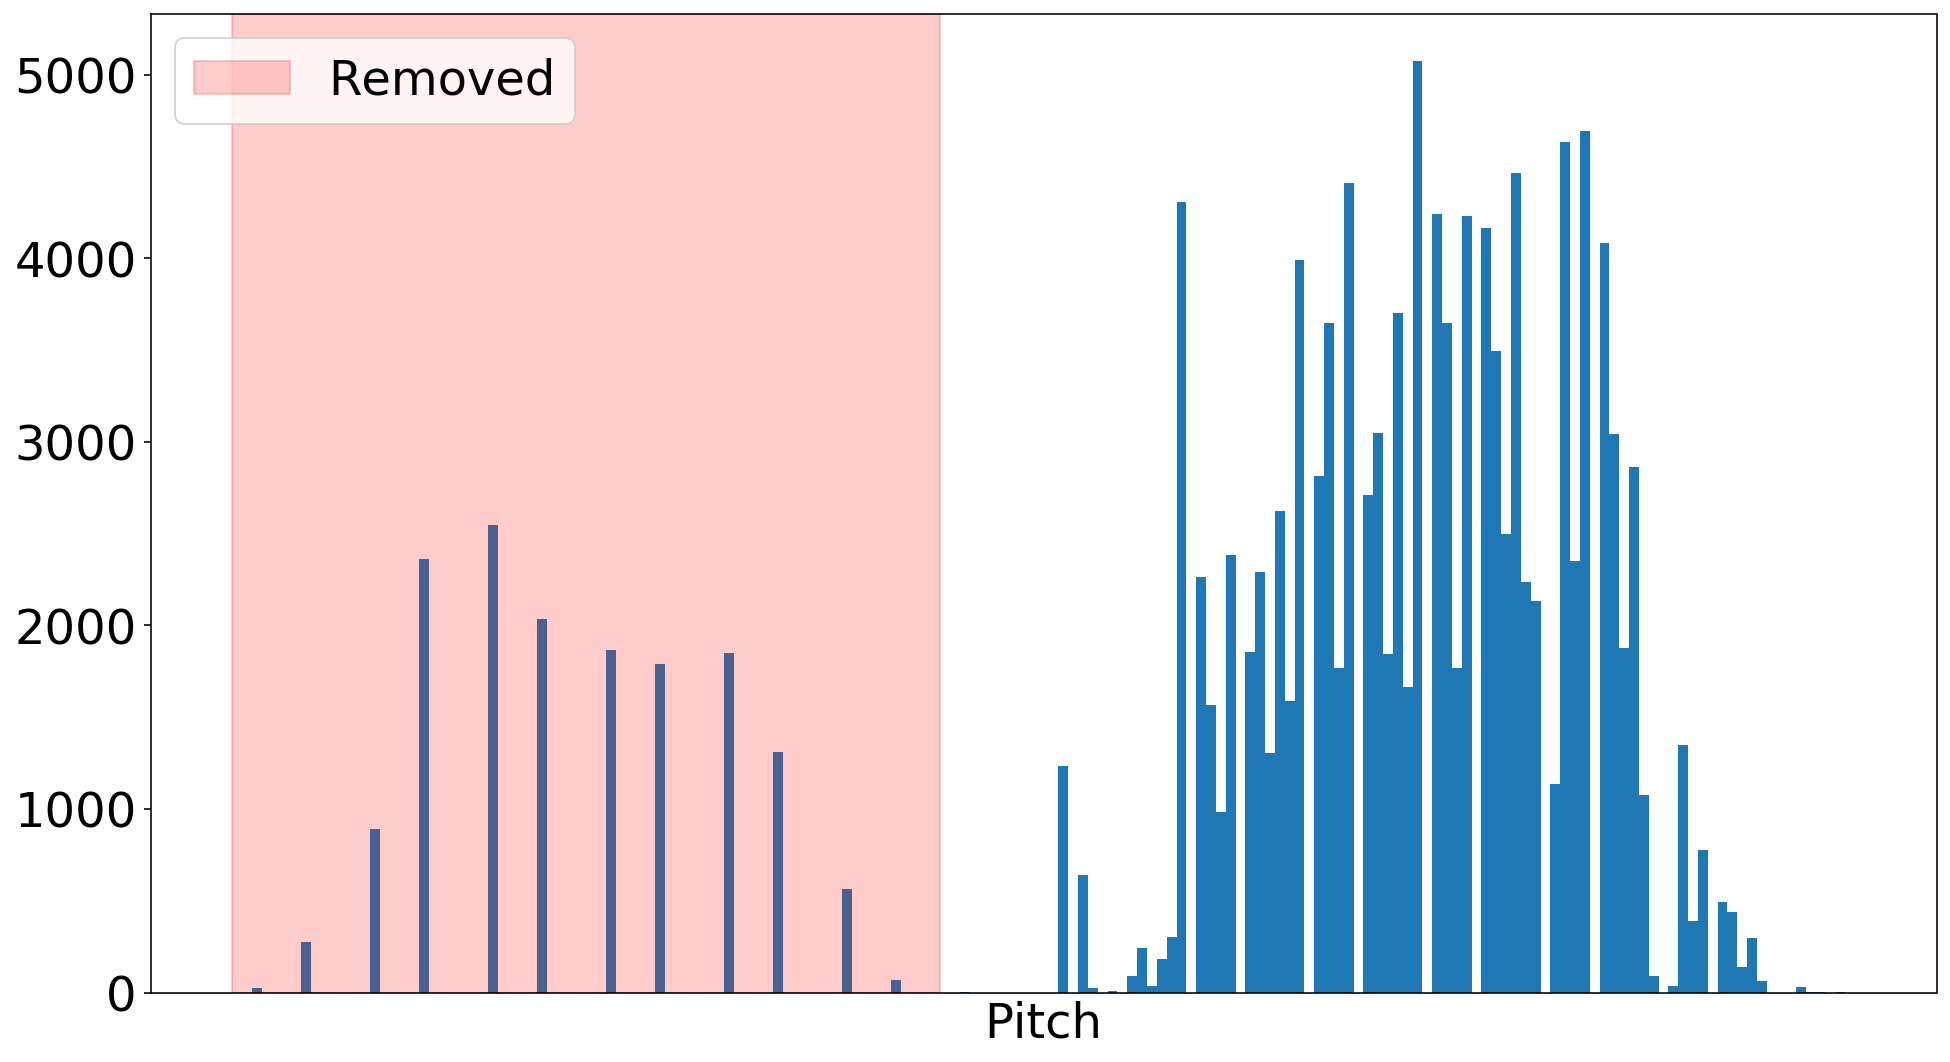

In [26]:
#let's see how often each note shows up
ints=[]

pitch_test='A0'
int_test=pitch_dict[pitch_test]

pitch_test2='A-6'
int_test_low=0

for i in pitches:    
    ints.append(pitch_dict[i])
    
bins=np.arange(0,max(ints))
ignored,ignored,ignored=plt.hist(ints,bins=bins)
plt.axvspan(int_test_low,int_test,color='r',alpha=0.2,label='Removed')
plt.xlabel('Pitch')
plt.legend(loc='upper left')
plt.xticks(ticks=[],labels=[])
plt.savefig('./plots/Pitch_hist2.png',bbox_inches='tight')

    

# We could make our images significantly smaller by removing everything below A1

In [27]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

#I'm dropping our lowest octave down to 0 and moving up 8 so our images can be squares

pitch_dict={}

min_octave=0
num_octaves=8

notes=['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

96


In [29]:
fp=open("pitch_dict_convgan_final_fantasy.pkl",'wb')
pickle.dump(pitch_dict,fp)
fp.close()

In [30]:
def check_pitch(pitch):
    if len(pitch)==2:
        octave=int(pitch[-1])
    if len(pitch)==3:
        if '#' in pitch:
            octave=int(pitch[-1])
        if '-' in pitch:
            octave=int(pitch[1:])
        
    if octave>=0:
        return True
    else:
        return False

In [31]:
pixel_length=float(1/12) 
grid_out=[]

measures_per_image=2
image_width=int(4*measures_per_image/pixel_length)
image_height=int(num_pitches)
num_channels=int(4)
count=-1

for i in range(len(filenames)):
    filename=filenames[i]
    if i in idx_keep:
        count+=1
        
        #populate pitches, durations, and offsets
        midi=converter.parse(filename)
        s2=instrument.partitionByInstrument(midi)
        pitches=[]
        offsets=[]
        durations=[]

        for part in s2.parts:
            print("song "+str(count)+" " +str(part))
            if 'Piano' in str(part):
                notes_to_parse=part.recurse()
                for element in notes_to_parse:

                    if isinstance(element,note.Note):
                        #only keep if pitch is in octave 1 or greater
                        if check_pitch(element.nameWithOctave):
                            offsets.append(element.offset)
                            pitches.append(element.nameWithOctave)
                            durations.append(element.duration.quarterLength)

                    elif isinstance(element,chord.Chord):

                        for pitch in element.pitches:
                            #only keep if pitch is in octave 1 or greater
                            if check_pitch(pitch.nameWithOctave):
                                offsets.append(element.offset)
                                pitches.append(pitch.nameWithOctave)
                                durations.append(element.duration.quarterLength)
        #print(pitches)

        if len(offsets)>0:
                                
            if max(offsets)>num_channels*measures_per_image*4:
                #the song is long enough

                #create grid
                grid_temp=np.zeros((num_pitches,int(max(offsets)/pixel_length)))

                for j in range(len(offsets)):


                    offset_temp=offsets[j]
                    pitch_temp=pitches[j]
                    duration_temp=durations[j]
                    



                    #find column grid value
                    column_start_idx=int(offset_temp/pixel_length)
                    delta=duration_temp/pixel_length
                    column_end_idx=int(column_start_idx+delta)

                    #find row grid value
                    row_idx=int(pitch_dict[pitch_temp])

                    grid_temp[row_idx,column_start_idx:column_end_idx]=1



                grid_out.append(grid_temp)
        

song 0 <music21.stream.Part Piano>
song 1 <music21.stream.Part Piano>
song 2 <music21.stream.Part Piano>
song 3 <music21.stream.Part Piano>
song 4 <music21.stream.Part Piano>
song 5 <music21.stream.Part Piano>
song 6 <music21.stream.Part Piano>
song 7 <music21.stream.Part Piano>
song 8 <music21.stream.Part Piano>
song 9 <music21.stream.Part Piano>
song 10 <music21.stream.Part Piano>
song 11 <music21.stream.Part Piano>
song 12 <music21.stream.Part Piano>
song 13 <music21.stream.Part Piano>
song 14 <music21.stream.Part Piano>
song 15 <music21.stream.Part Piano>
song 16 <music21.stream.Part Piano>
song 17 <music21.stream.Part Piano>
song 18 <music21.stream.Part Piano>
song 19 <music21.stream.Part Piano>
song 20 <music21.stream.Part Viola>
song 21 <music21.stream.Part Piano>
song 22 <music21.stream.Part Piano>
song 23 <music21.stream.Part object at 0x7f1cb580f438>
song 24 <music21.stream.Part object at 0x7f1cb767c0b8>
song 25 <music21.stream.Part Piano>
song 26 <music21.stream.Part Piano>


song 163 <music21.stream.Part Piano>
song 164 <music21.stream.Part Piano>
song 165 <music21.stream.Part Piano>
song 166 <music21.stream.Part Piano>
song 167 <music21.stream.Part Violin>
song 167 <music21.stream.Part object at 0x7f1cb71a6a90>
song 167 <music21.stream.Part Viola>
song 167 <music21.stream.Part Violoncello>
song 168 <music21.stream.Part Piano>
song 169 <music21.stream.Part Piano>
song 170 <music21.stream.Part object at 0x7f1cbc504240>
song 171 <music21.stream.Part Piano>
song 172 <music21.stream.Part Piano>
song 173 <music21.stream.Part Piano>
song 174 <music21.stream.Part Piano>
song 175 <music21.stream.Part Piano>
song 176 <music21.stream.Part Trombone>
song 176 <music21.stream.Part Tuba>
song 177 <music21.stream.Part Piano>
song 178 <music21.stream.Part Piano>
song 179 <music21.stream.Part Piano>
song 180 <music21.stream.Part Voice>
song 180 <music21.stream.Part Piano>
song 181 <music21.stream.Part Piano>
song 182 <music21.stream.Part Piano>
song 183 <music21.stream.Par

In [32]:
print(image_width)
print(image_height)

96
96


In [33]:
print(len(grid_out))
print(len(idx_keep))

159
187


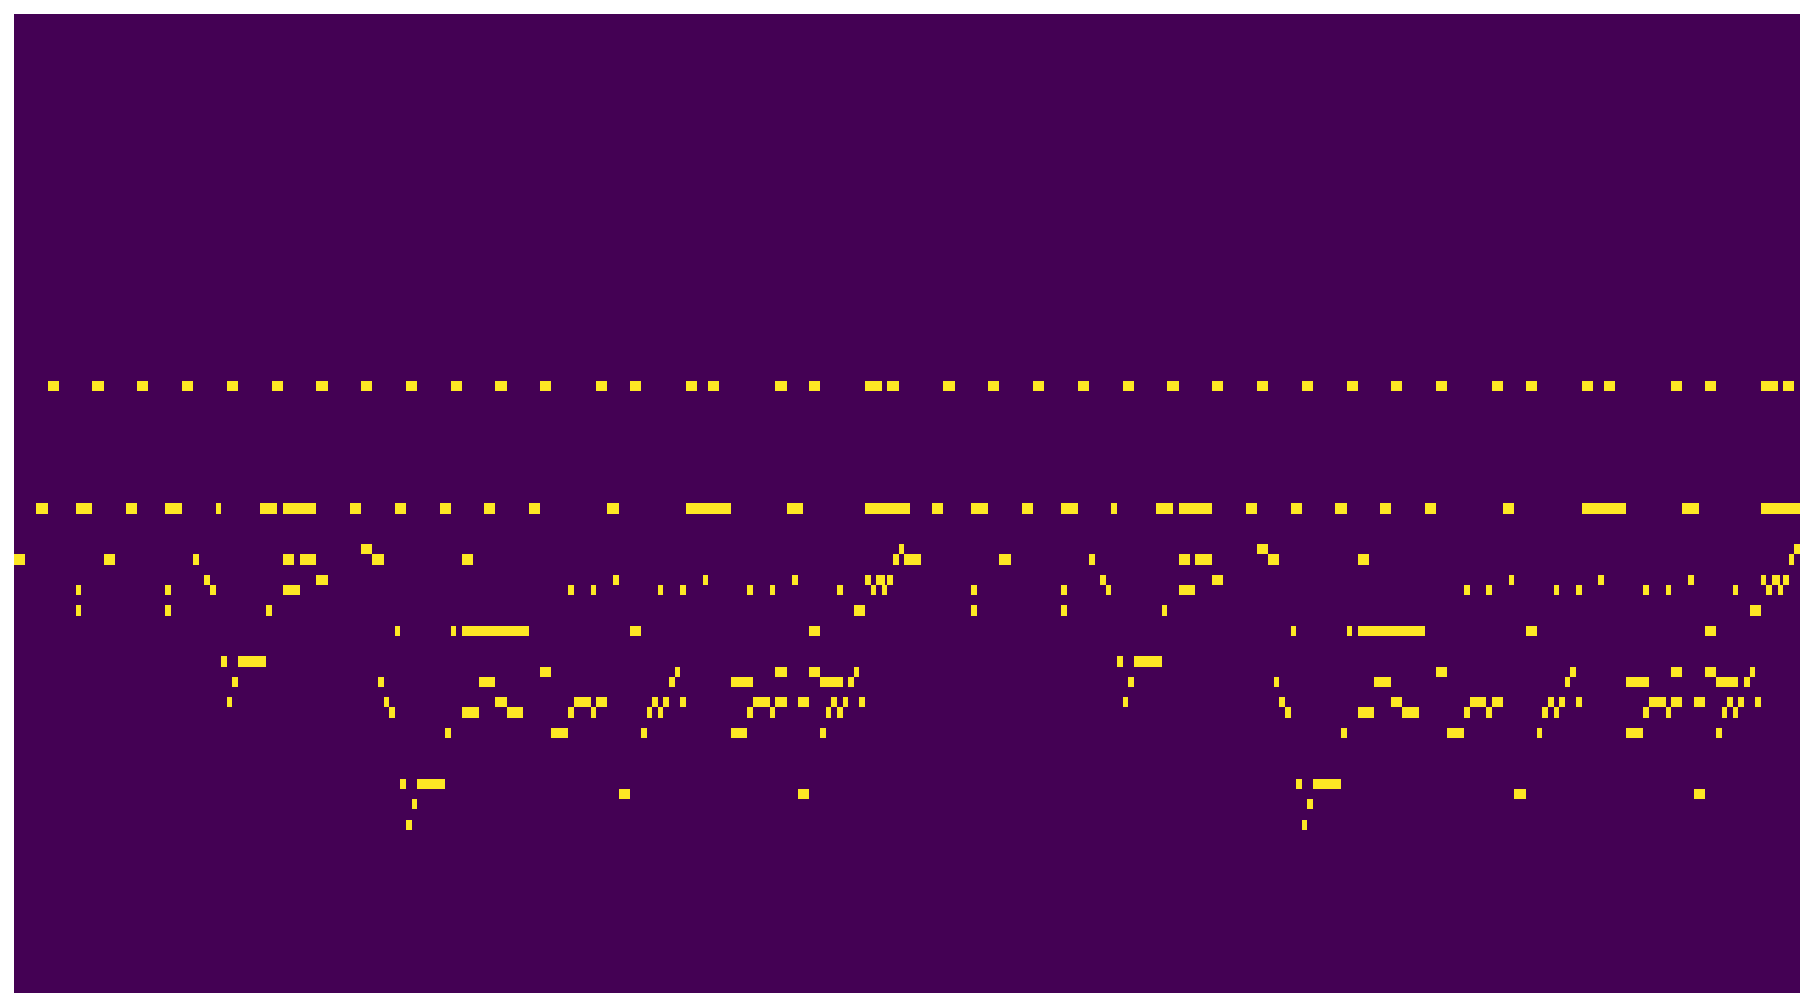

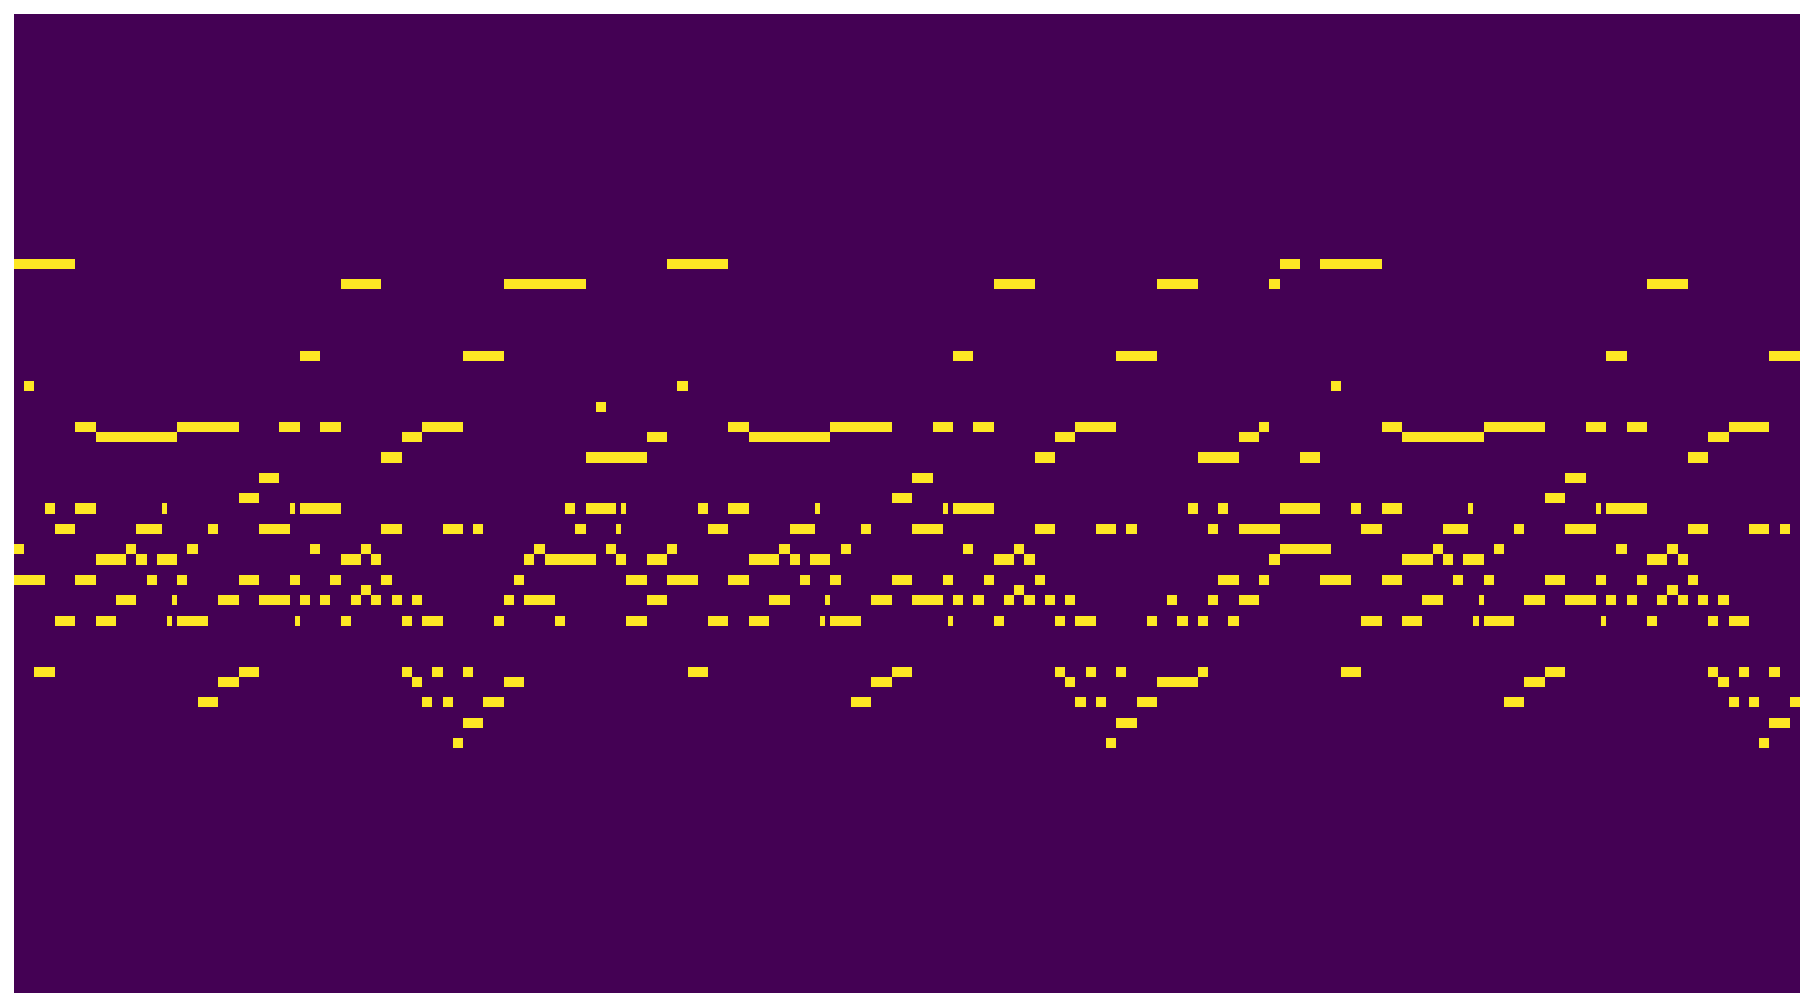

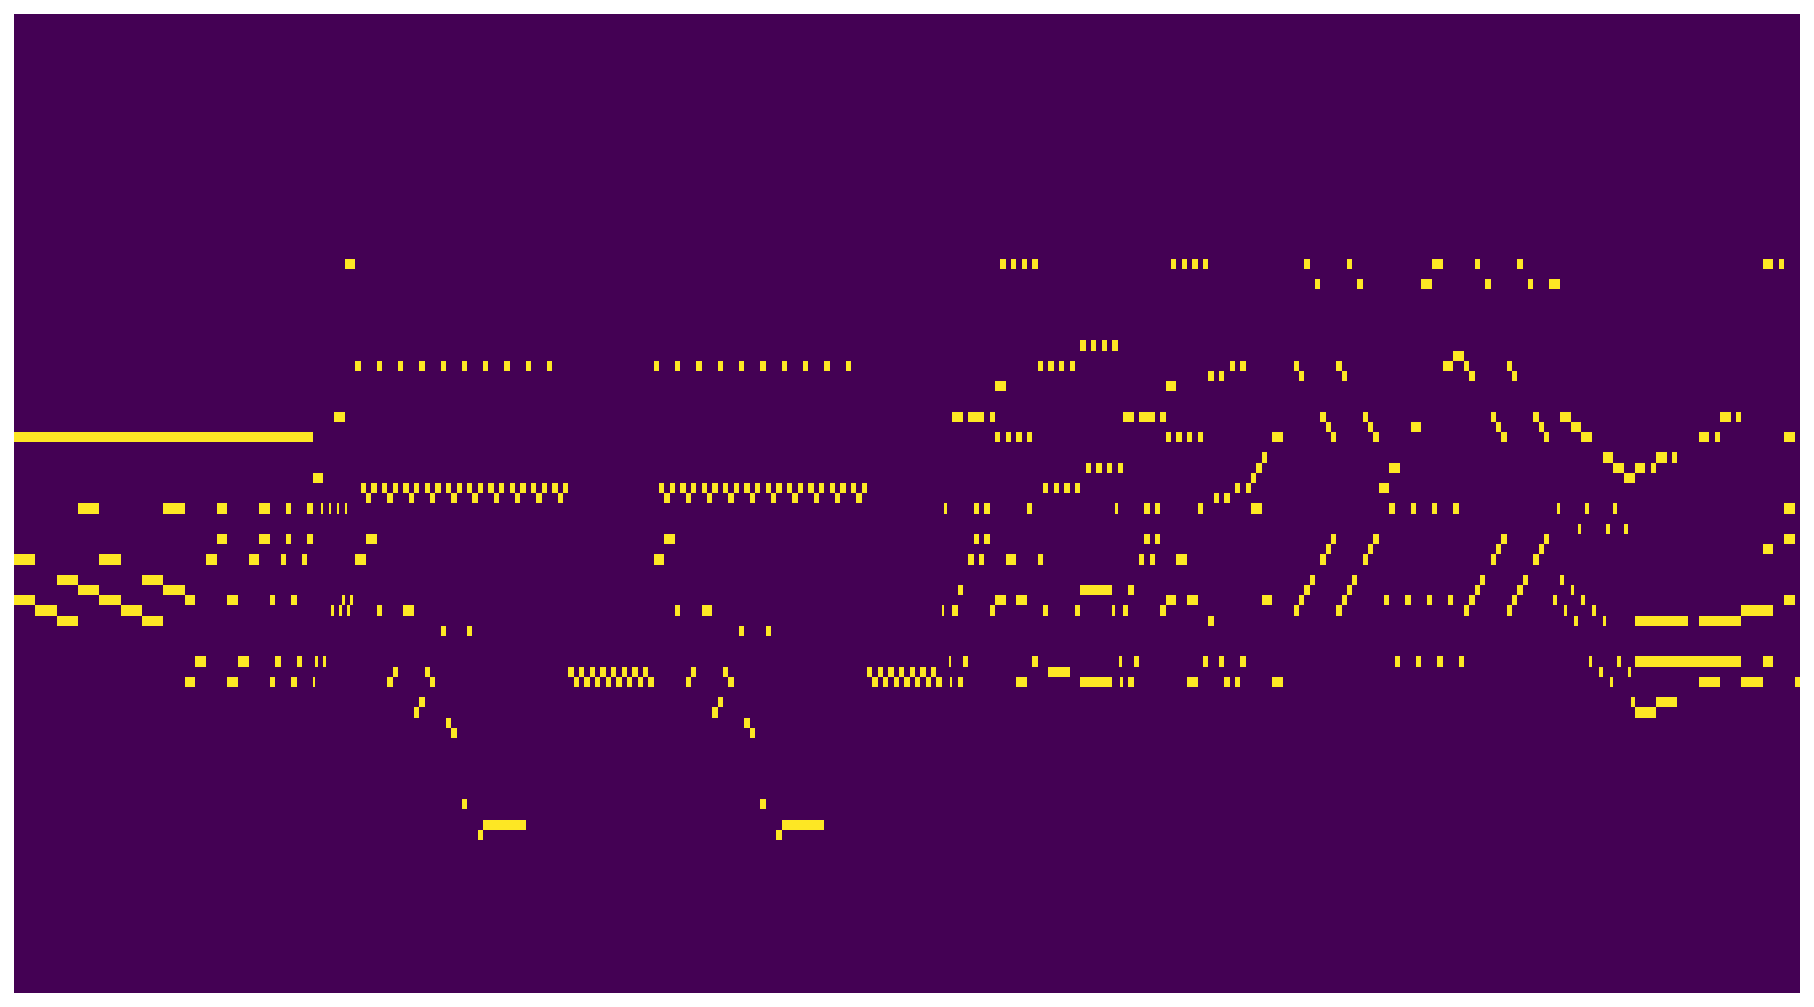

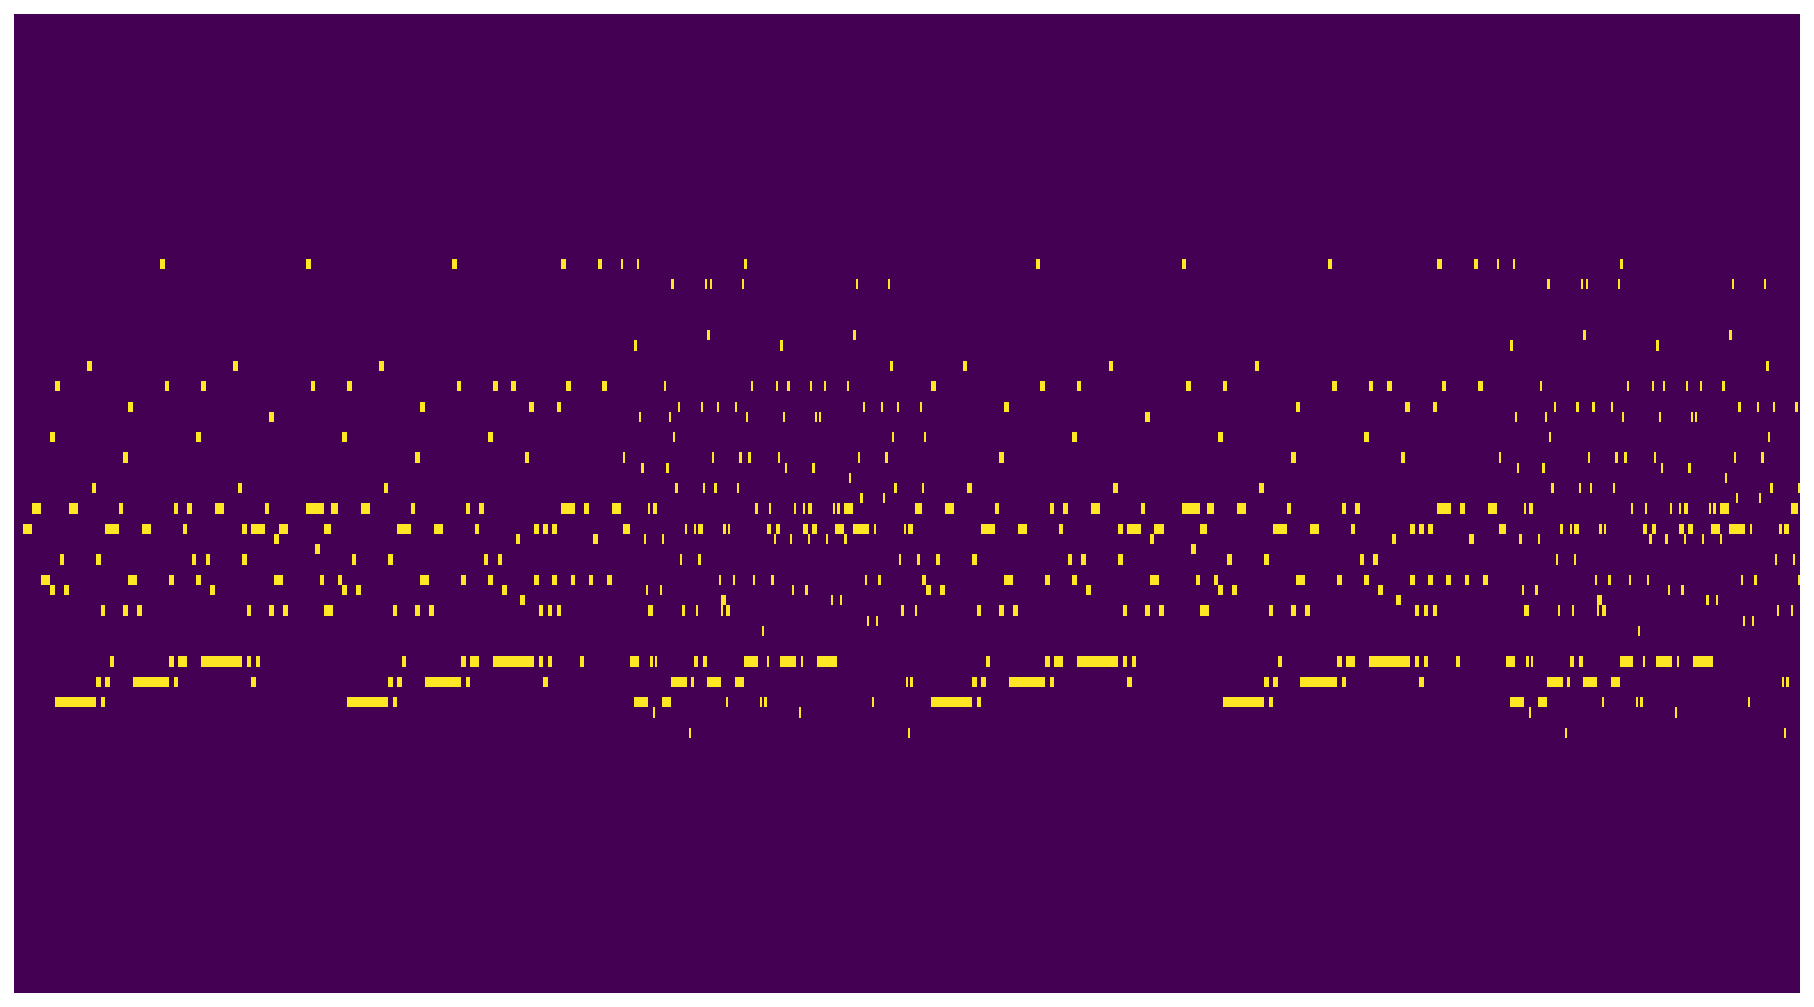

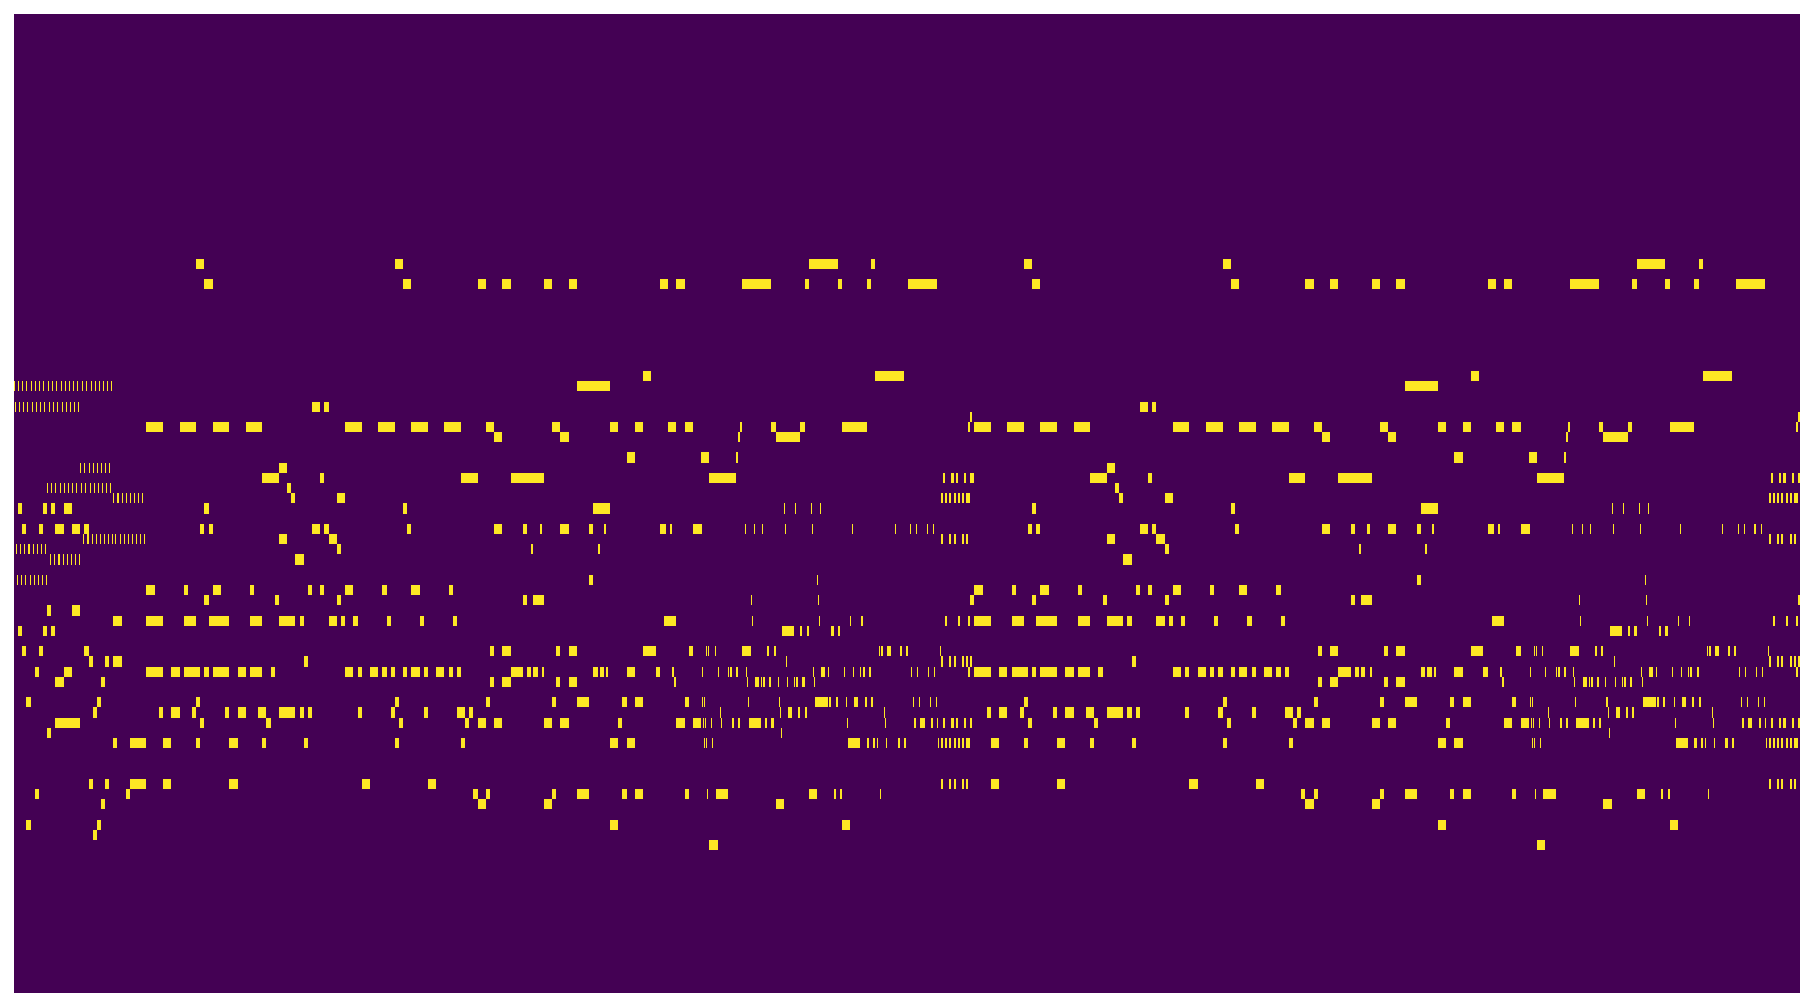

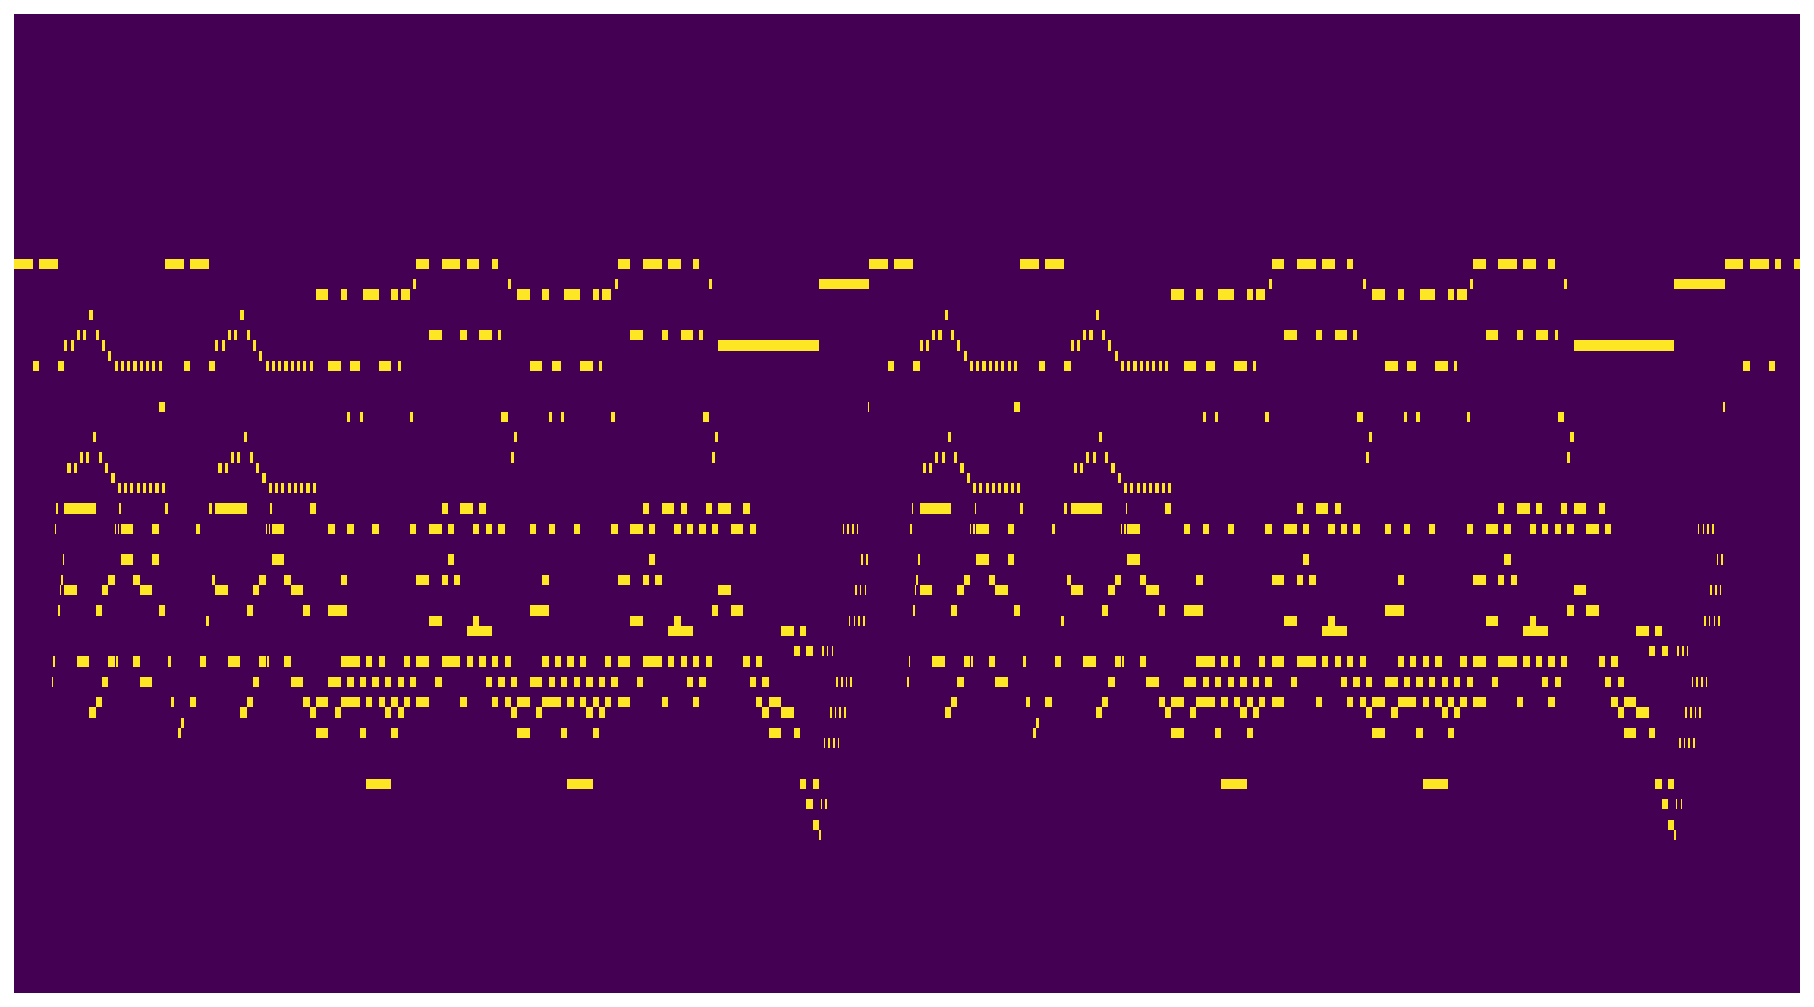

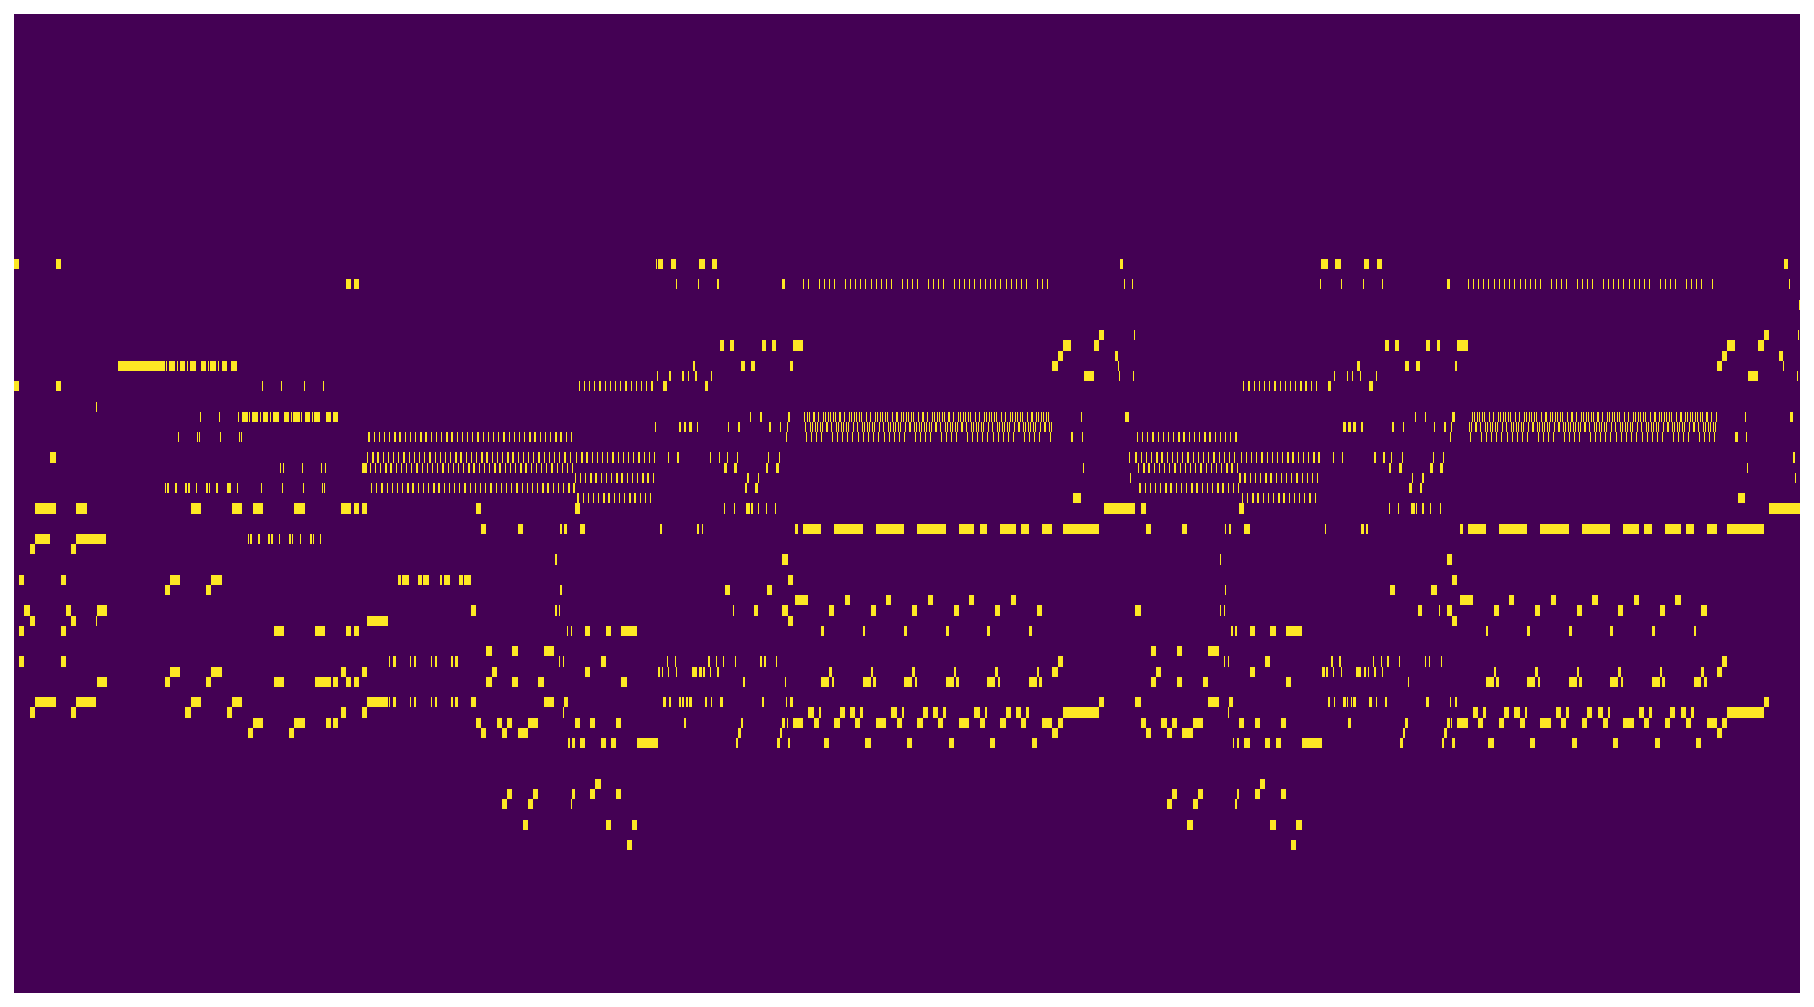

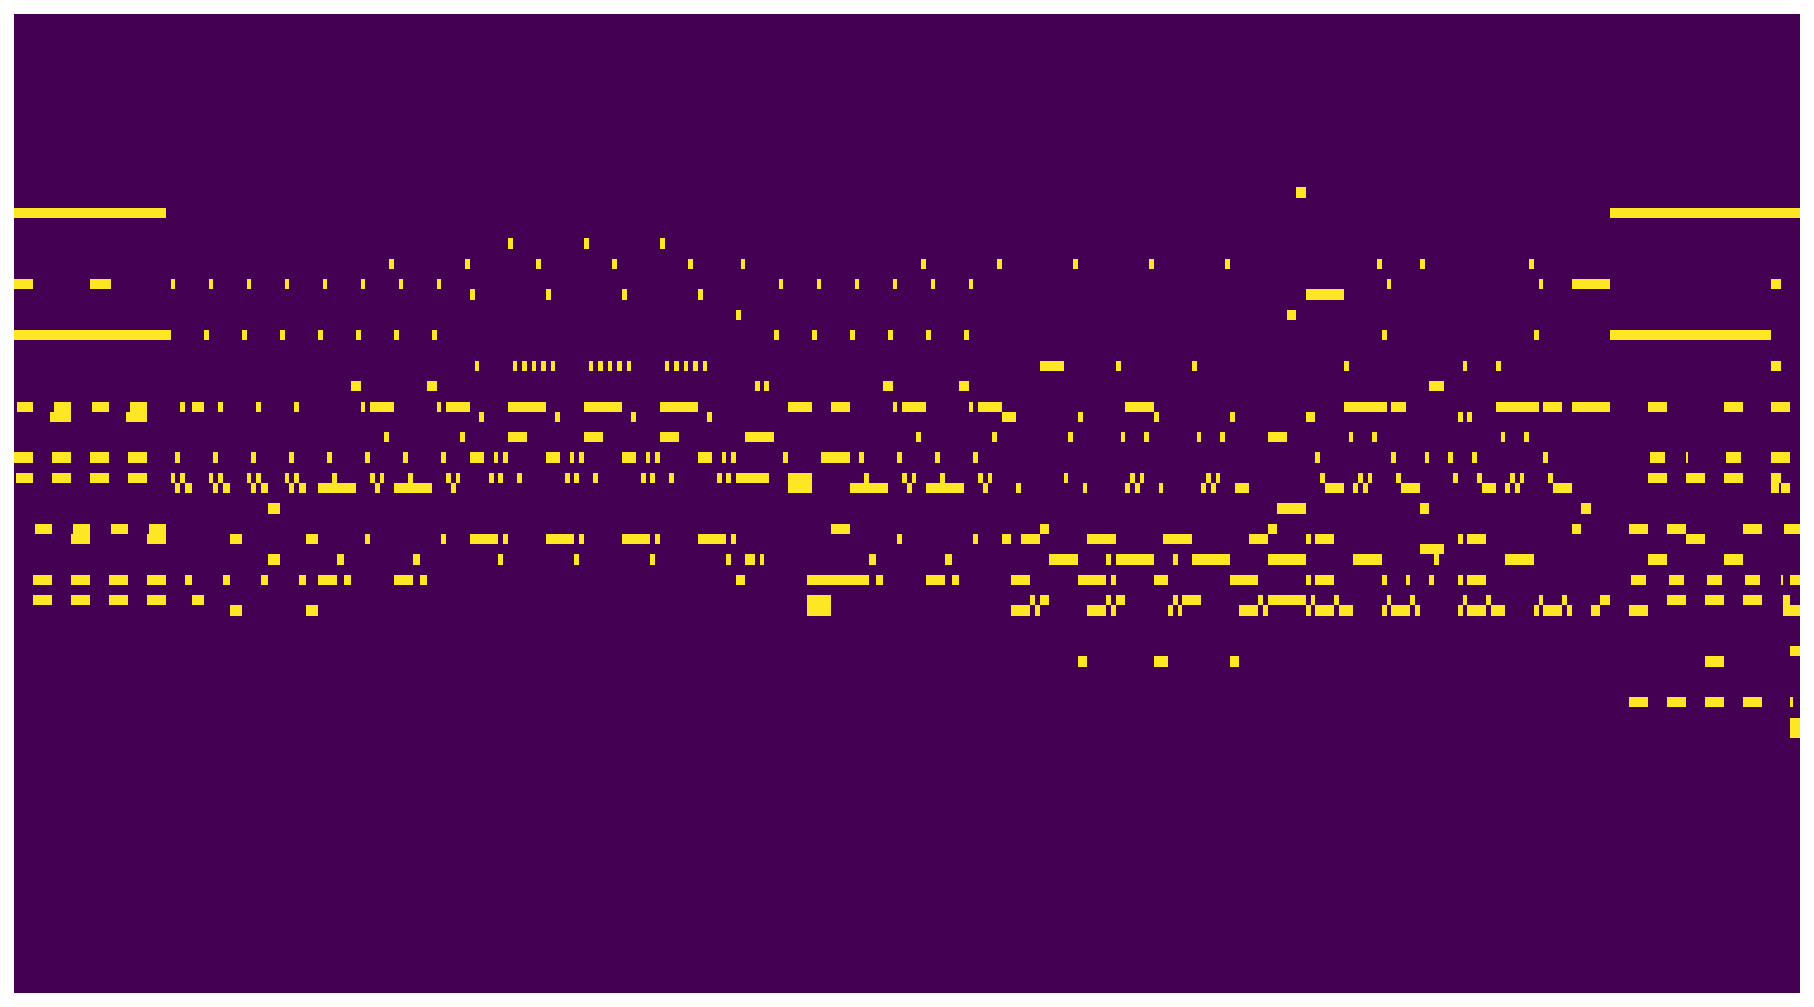

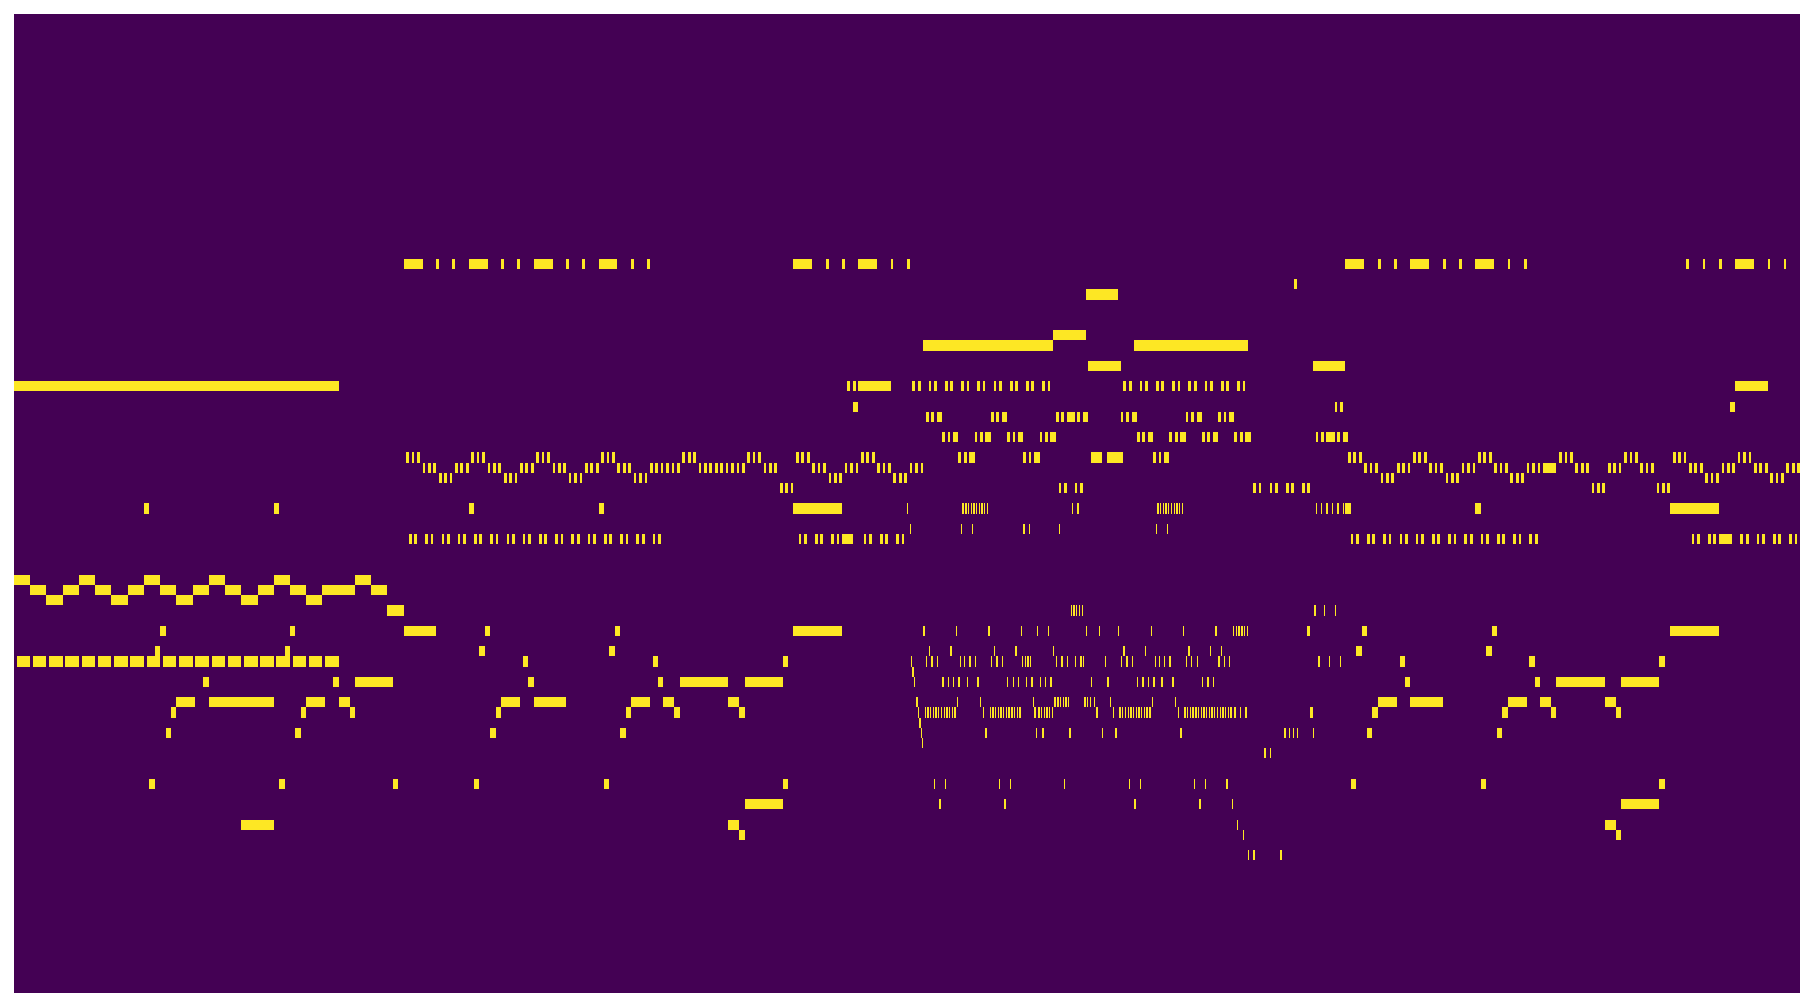

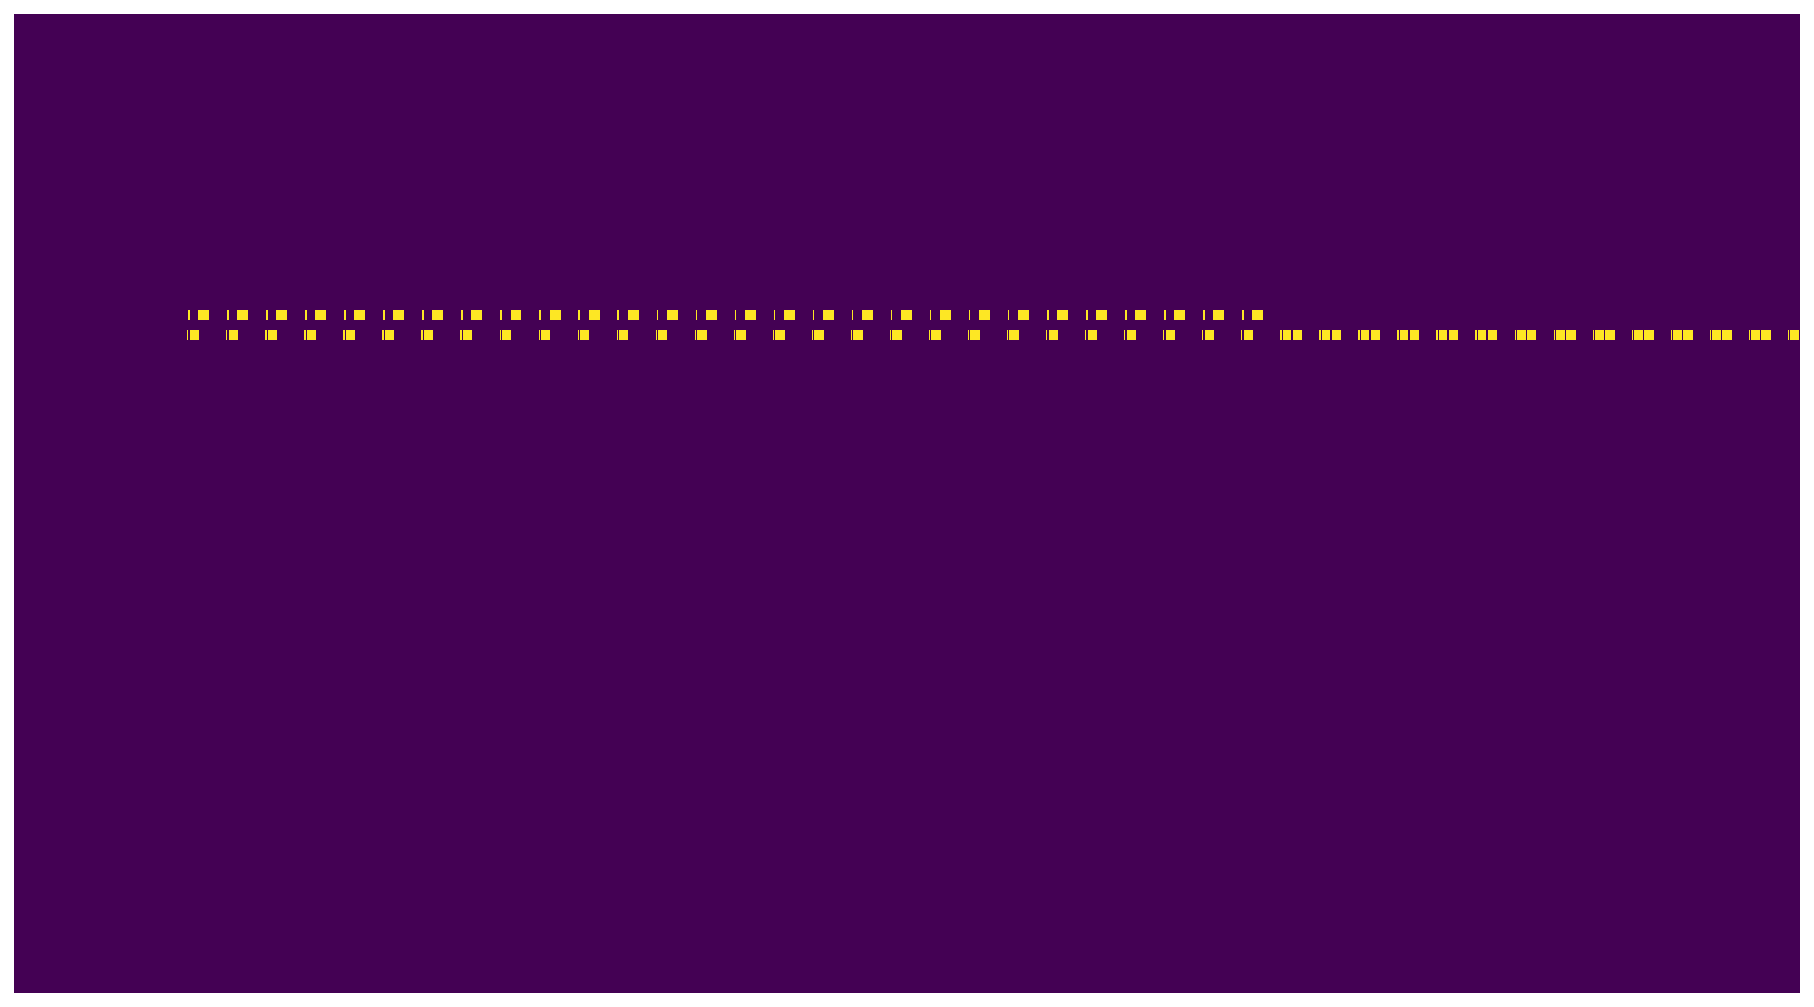

In [34]:
idx_all=np.arange(len(grid_out))
num_plot=10
for i in range(num_plot):
    idx=int(np.random.choice(idx_all,size=1))
    plt.imshow(grid_out[idx],extent=[-10,10,-1,1],aspect='auto')
    plt.axis('off')
    plt.show()

# OK so we have 159 songs for training

Now we just need to do a bit more manipulating to make them into the right shape

(row,column,channel)

In [35]:
print(grid_out[0].shape)
print(grid_out[1].shape)
print(image_width*num_channels)

(96, 3012)
(96, 1242)
384


In [36]:
samples=0
for i in range(len(grid_out)):
    
    images=math.floor(grid_out[i].shape[1]/(image_width))
    samples+=images-(num_channels-1) #the total amount of training data we can have by striding by 1
    
print(samples)

4734


# So for each song

- break the song up into images
- create training data by stacking num_channels images together and then striding by 1

In [37]:
ins=np.zeros((samples,image_height,image_width,num_channels))
print(ins.shape)

sample_idx=-1

for i in range(len(grid_out)):
    
    num_images=math.floor(grid_out[i].shape[1]/(image_width))
    num_samples=num_images-(num_channels-1)
    
    images=np.zeros((image_height,image_width,num_images))
    
    for j in range(num_images):
        
        left_idx=0+j*image_width
        right_idx=image_width+j*image_width
        images[:,:,j]=grid_out[i][:,left_idx:right_idx]
        
    for k in range(num_samples):
        sample_idx+=1
        
        left_idx=k
        right_idx=k+num_channels
    
        ins[sample_idx,:,:,:]=images[:,:,left_idx:right_idx]
        
        
        
        
        
        

(4734, 96, 96, 4)


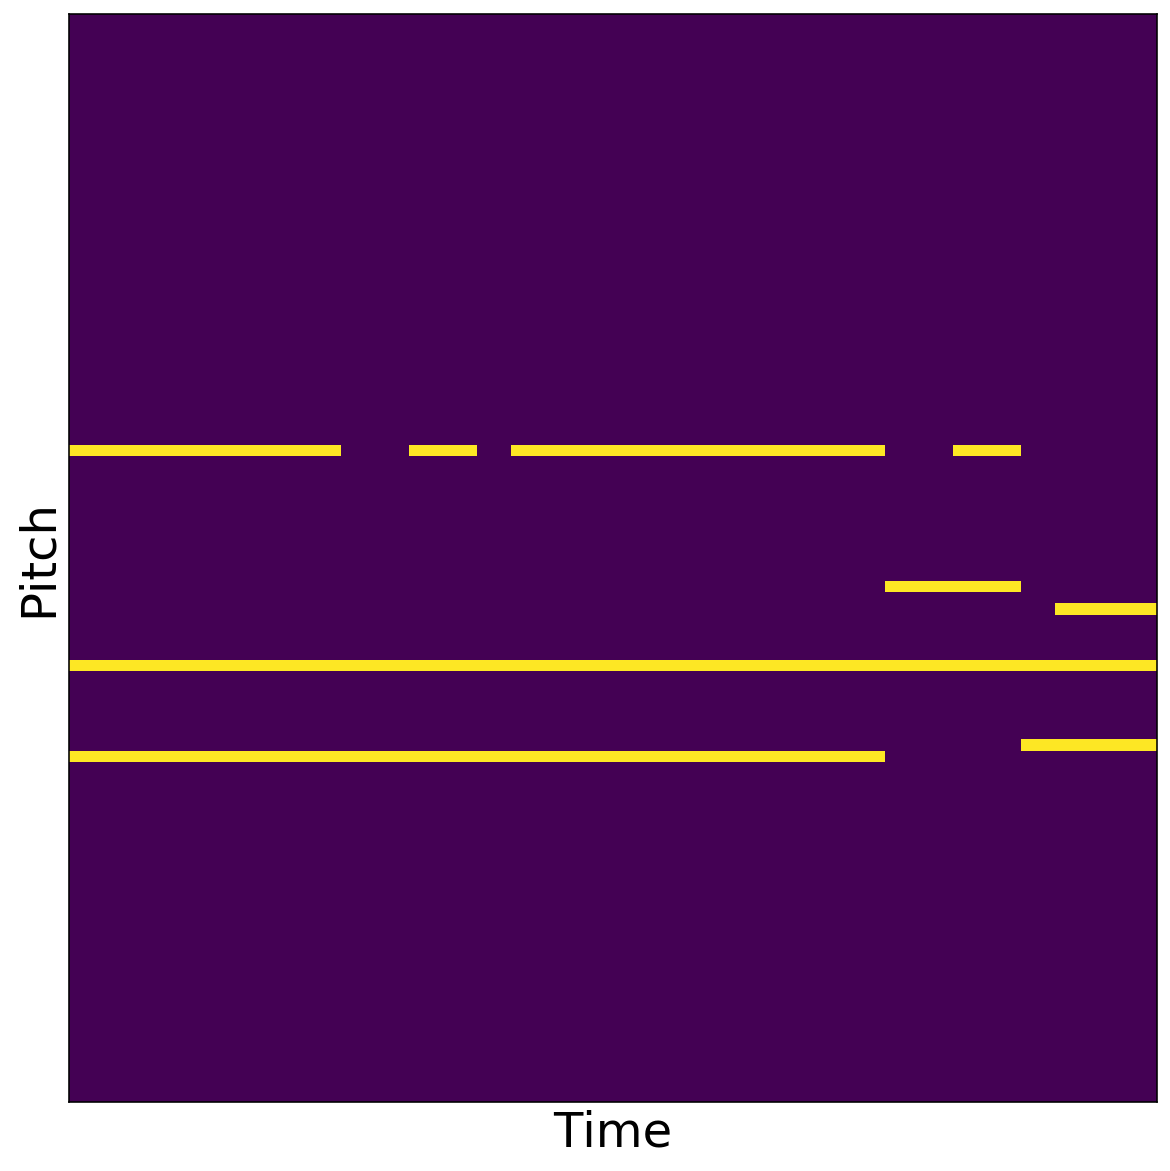

In [38]:
plt.rcParams['figure.figsize']=(10,10)
idx_all=np.arange(ins.shape[0])
image_idx=np.random.choice(idx_all,replace=False,size=1)
plt.imshow(ins[image_idx,:,:,0].reshape(96,96))
plt.xticks(ticks=[],labels=[])
plt.yticks(ticks=[],labels=[])
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.savefig('./plots/training_data_single_measure.png',bbox_inches='tight')

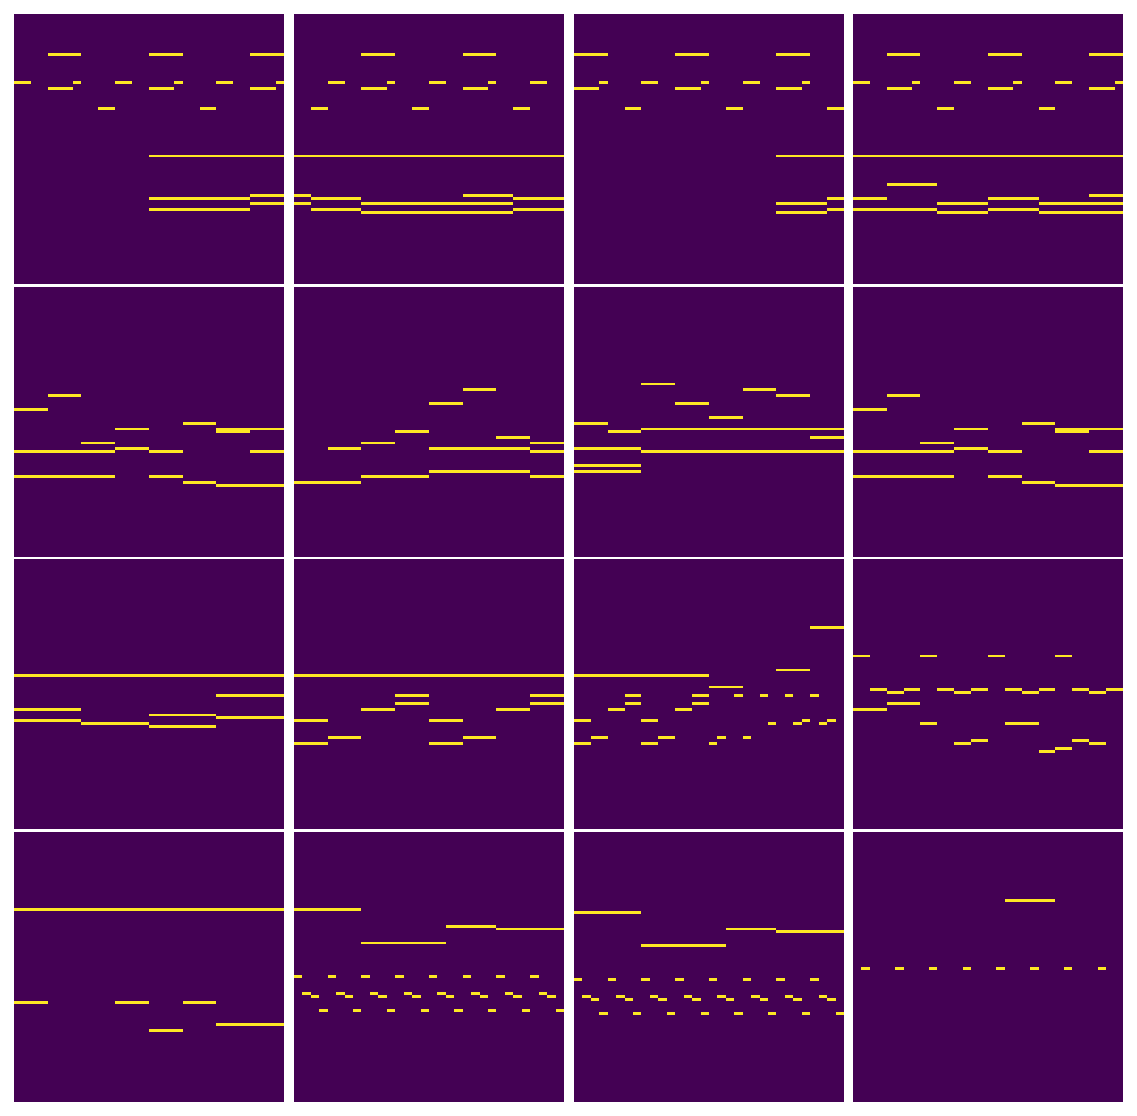

In [39]:
plt.rcParams['figure.figsize']=(10,10)
idx=54
fig,axs=plt.subplots(4,4)
idx_all=np.arange(ins.shape[0])
image_idxs=np.random.choice(idx_all,replace=False,size=4)

for i in range(4):
    for j in range(4):
        
        axs[i,j].imshow(ins[image_idxs[i],:,:,j])
        axs[i,j].axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.savefig('./plots/training_data.png',bbox_inches='tight')



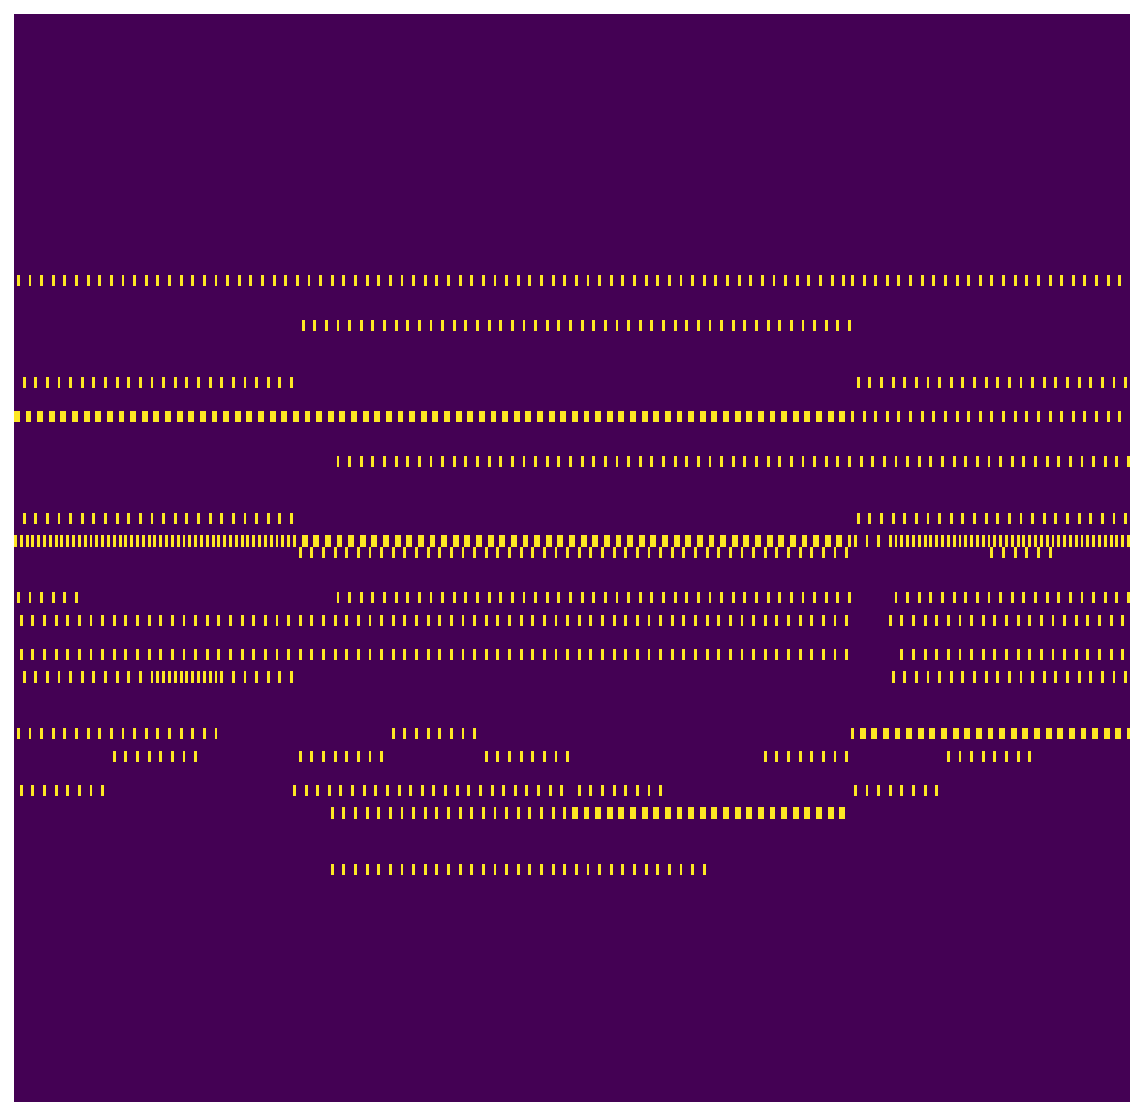

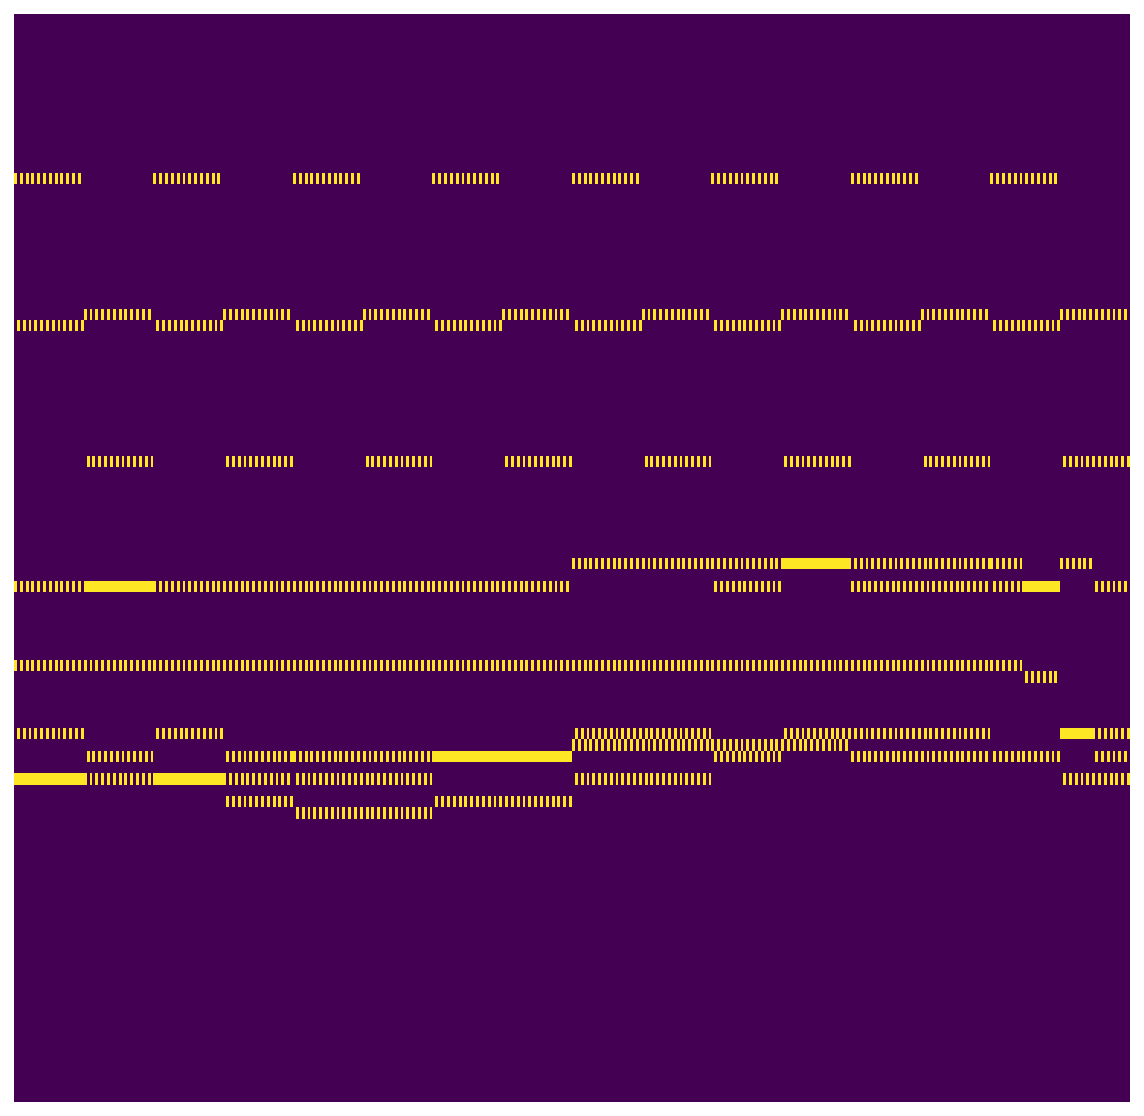

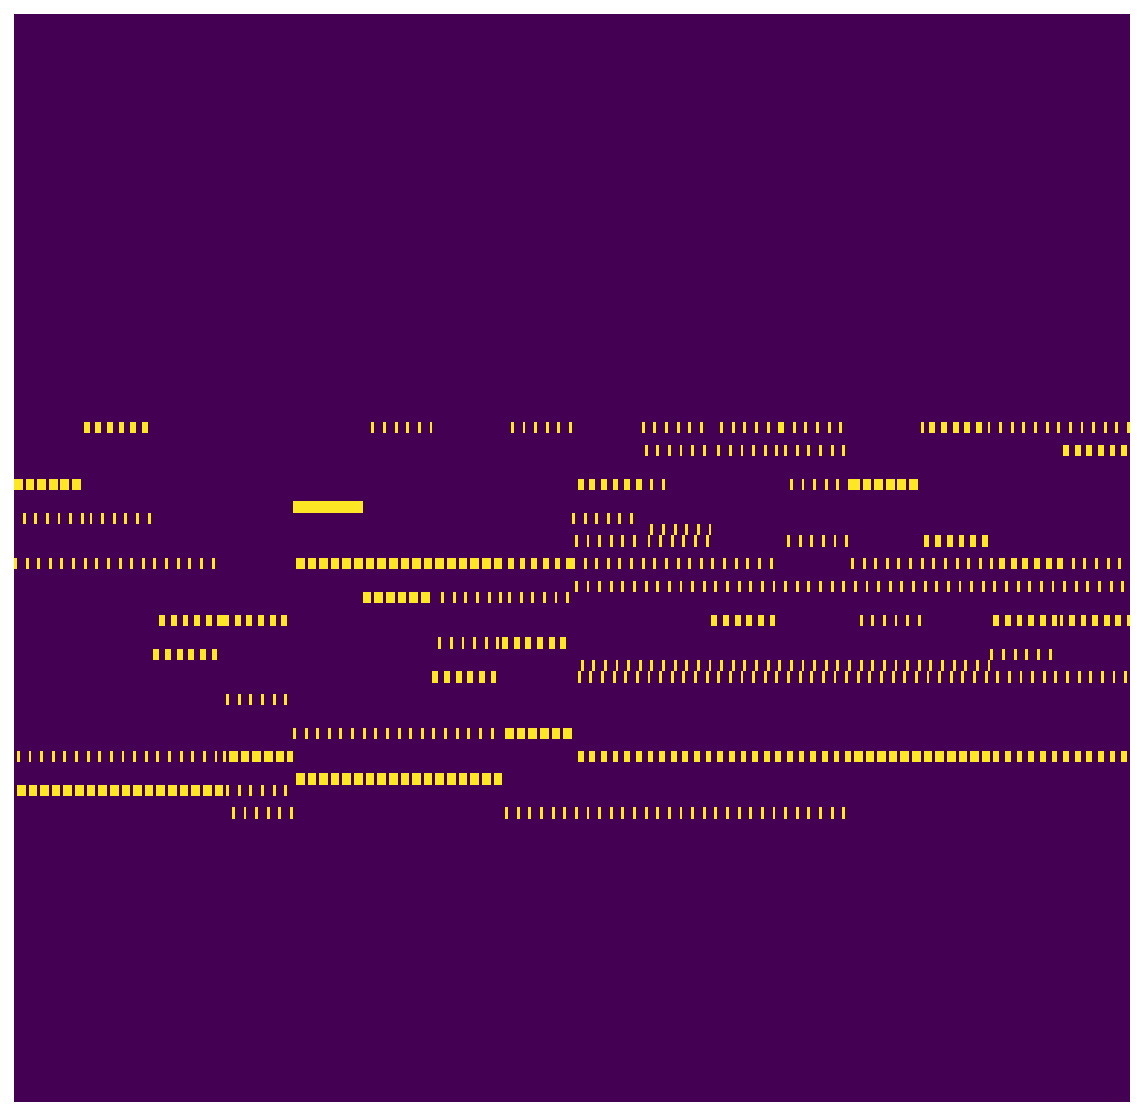

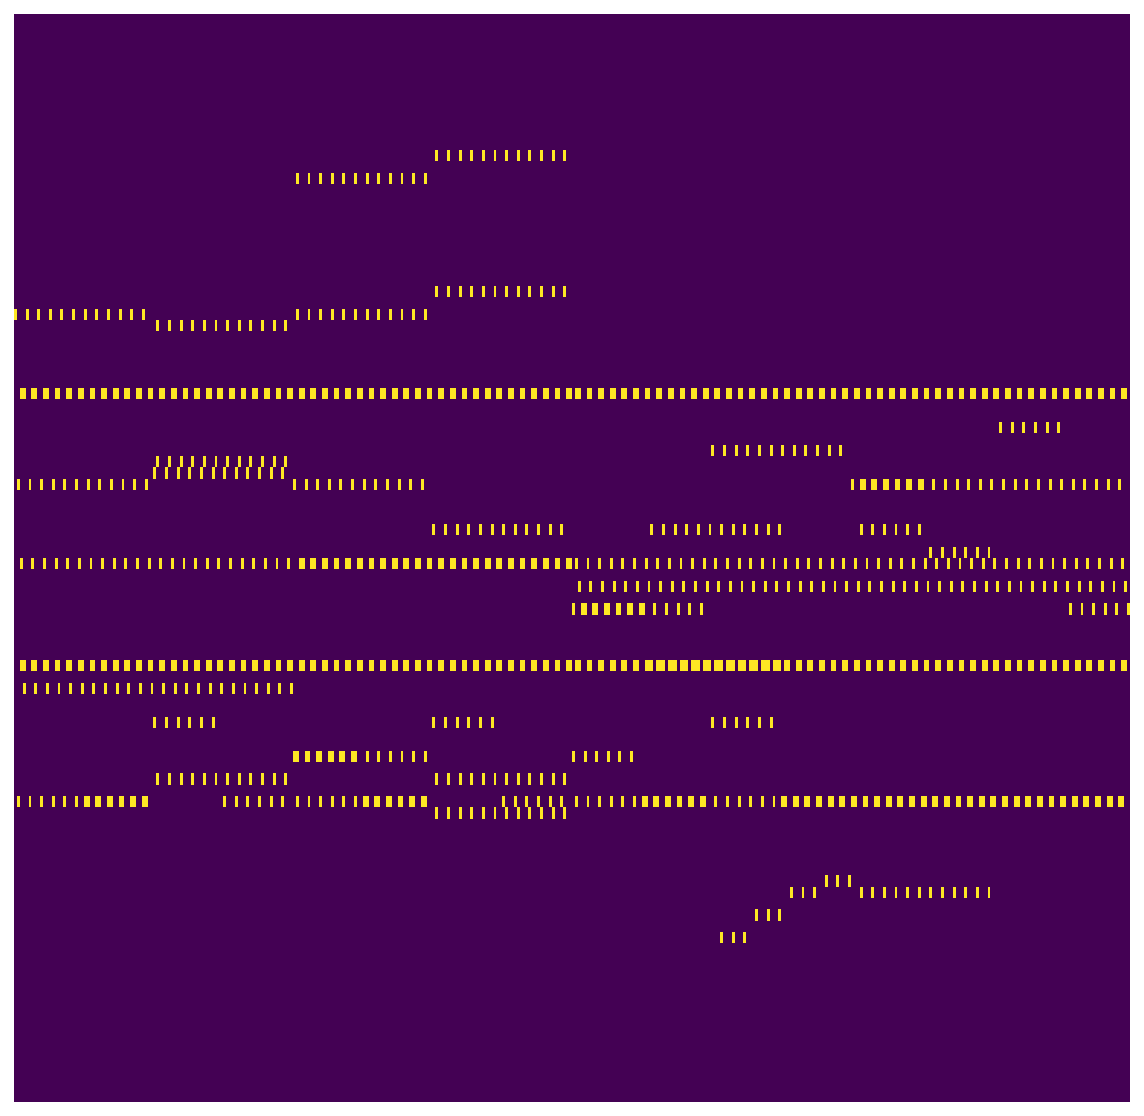

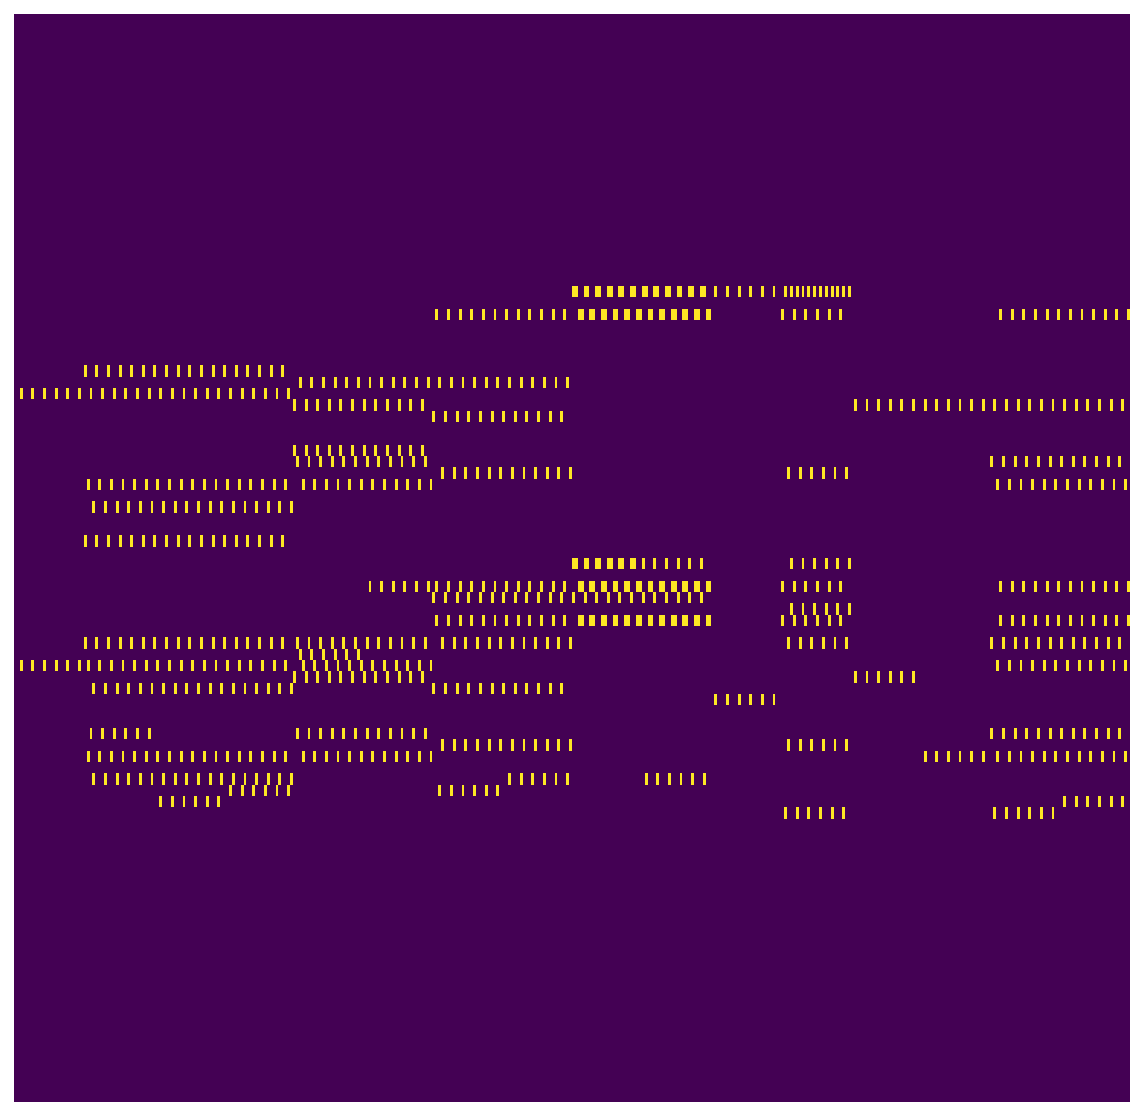

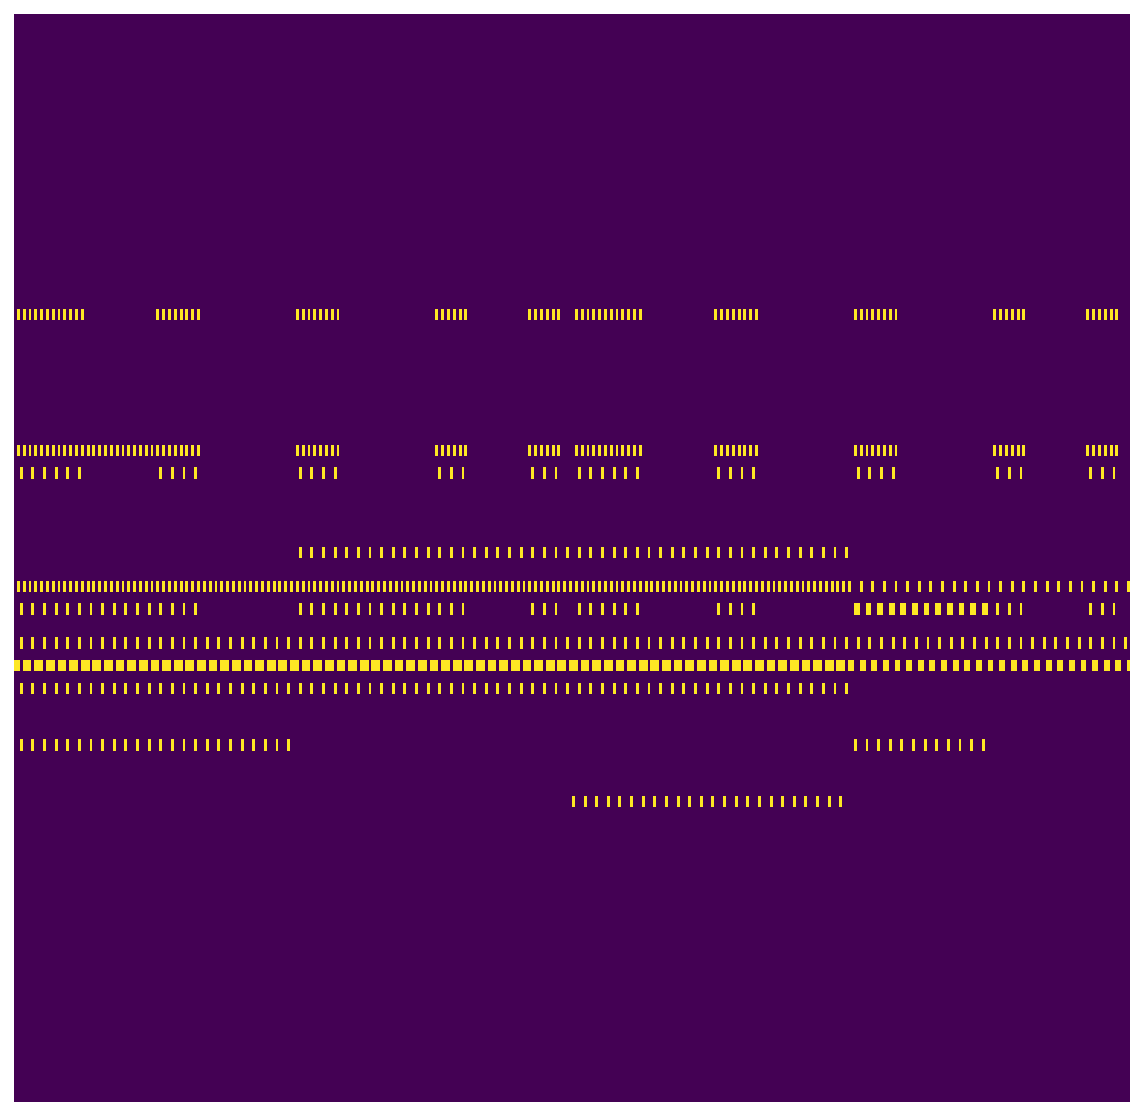

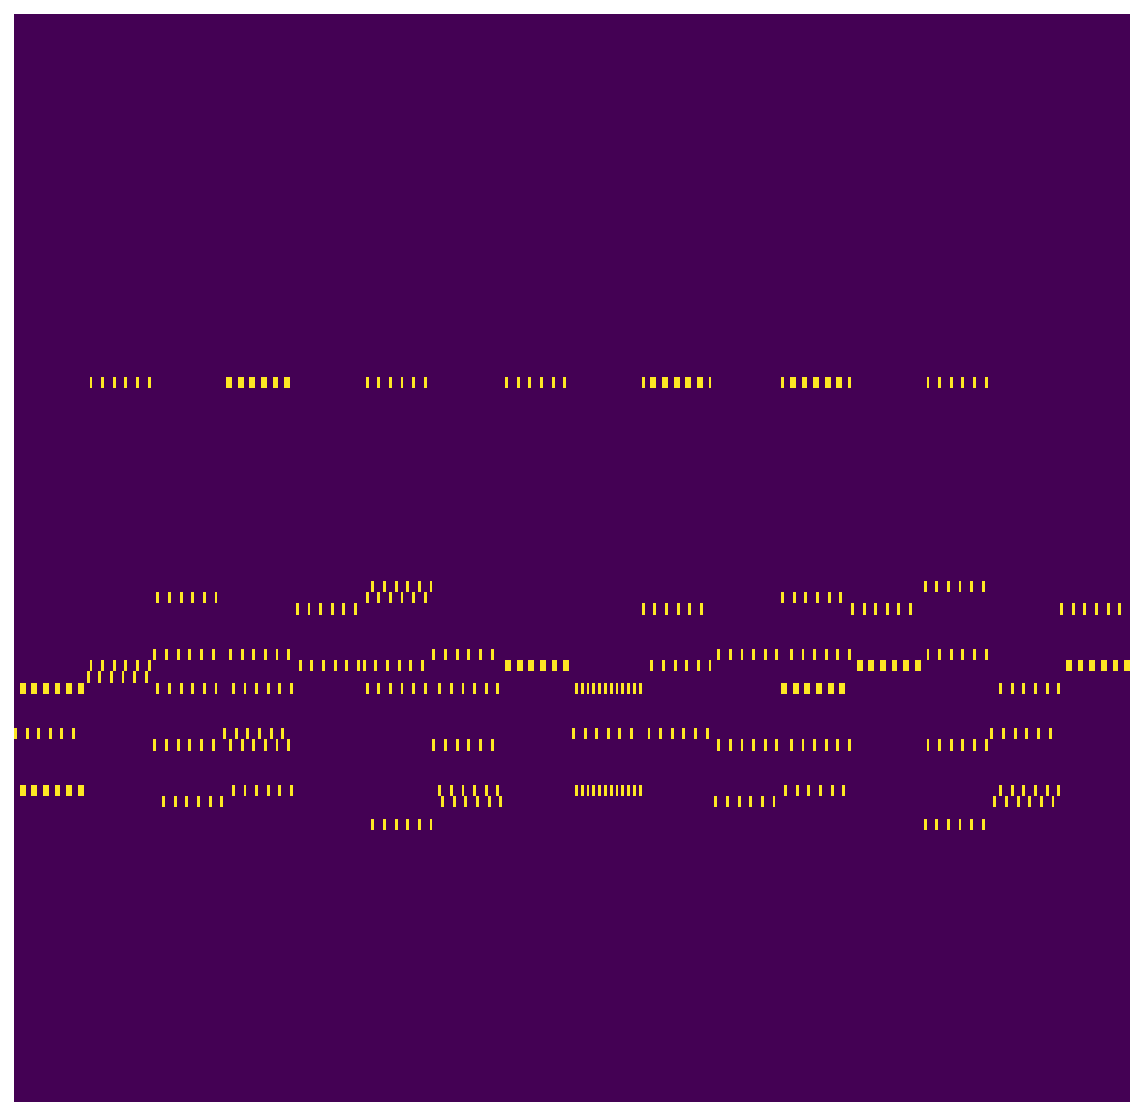

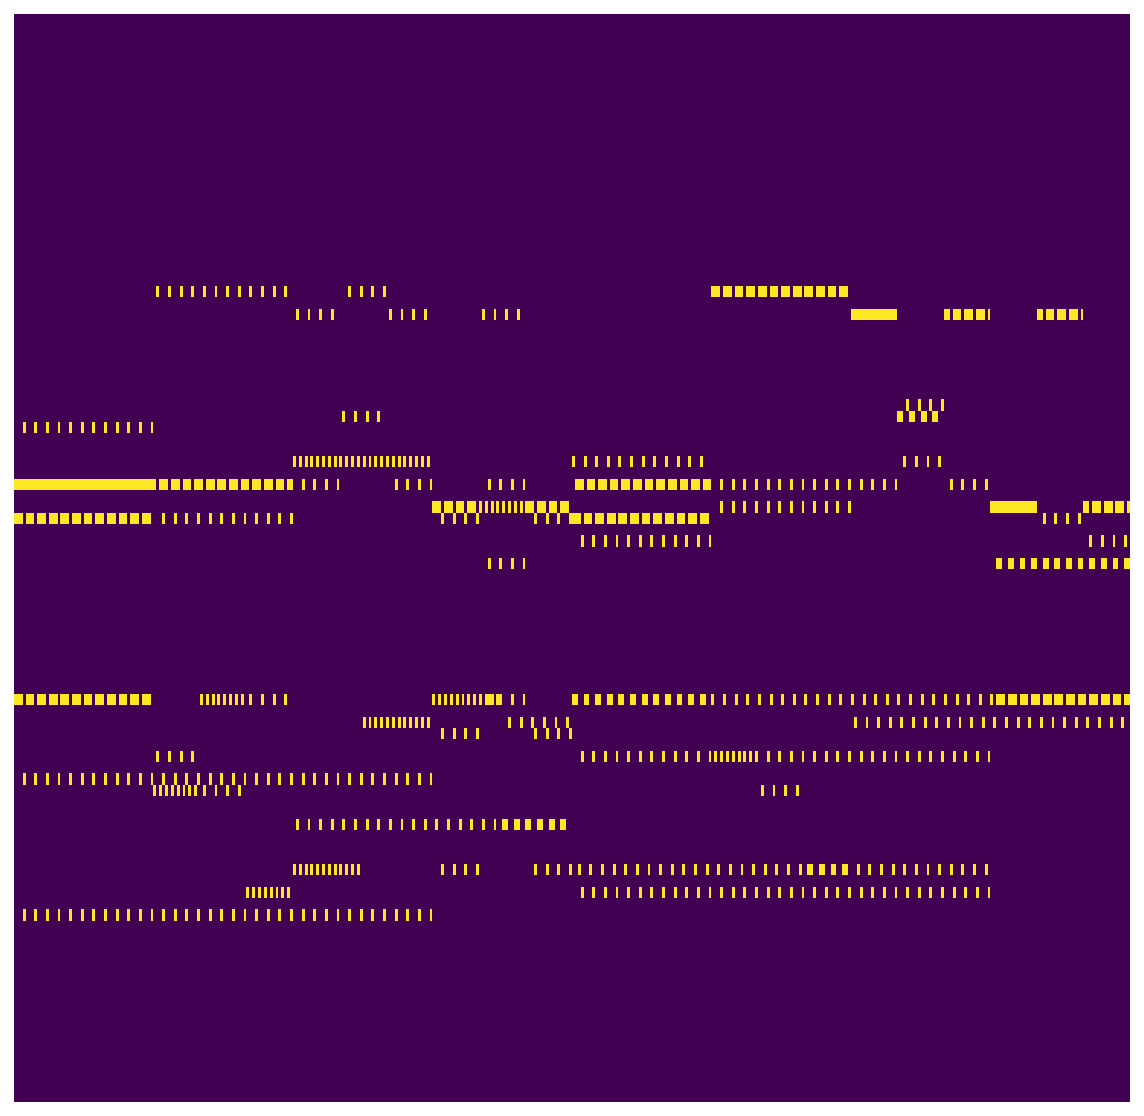

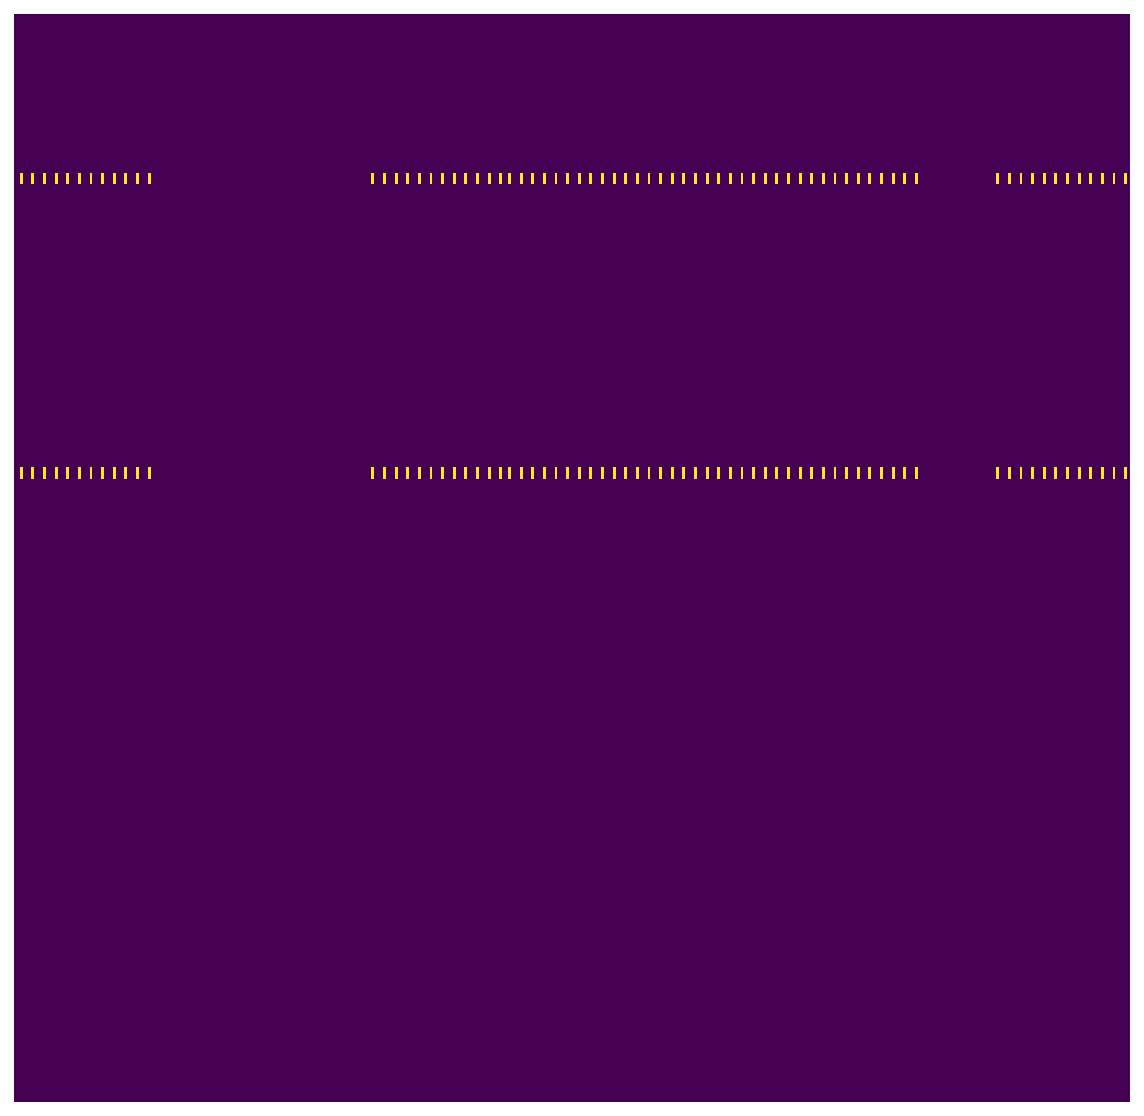

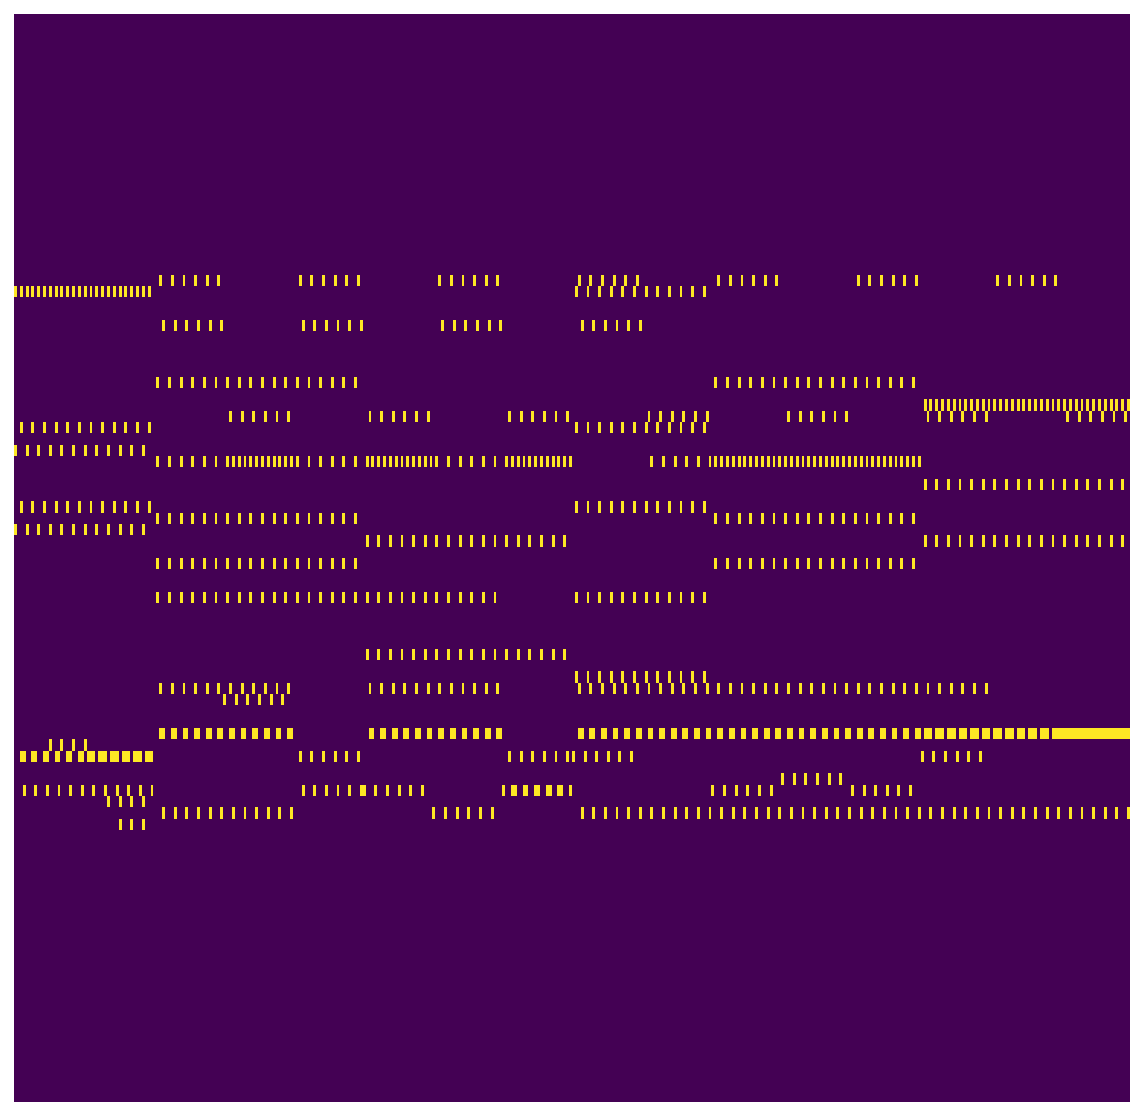

In [40]:
idx_all=np.arange(samples)
num_plot=10
for i in range(num_plot):
    
    idx=np.random.choice(idx_all,size=1)
    
    plt.imshow(ins[idx,:,:,:].reshape(image_height,image_width*num_channels),extent=[-10,10,-10,10],aspect='auto')
    plt.axis('off')
    plt.show()

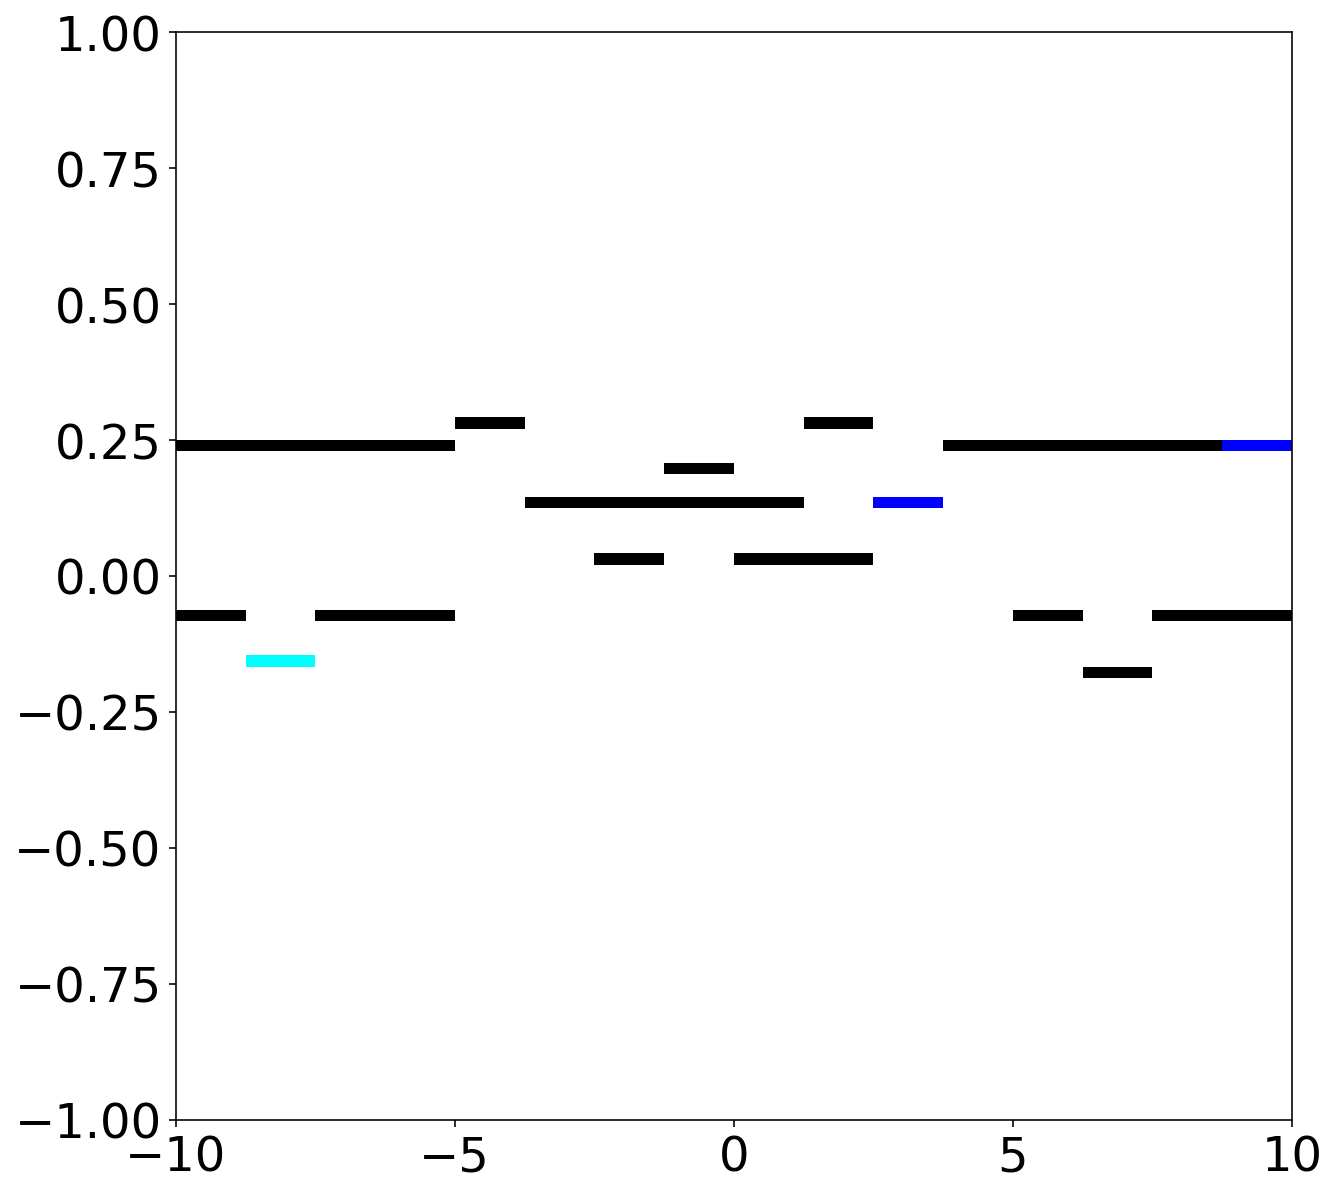

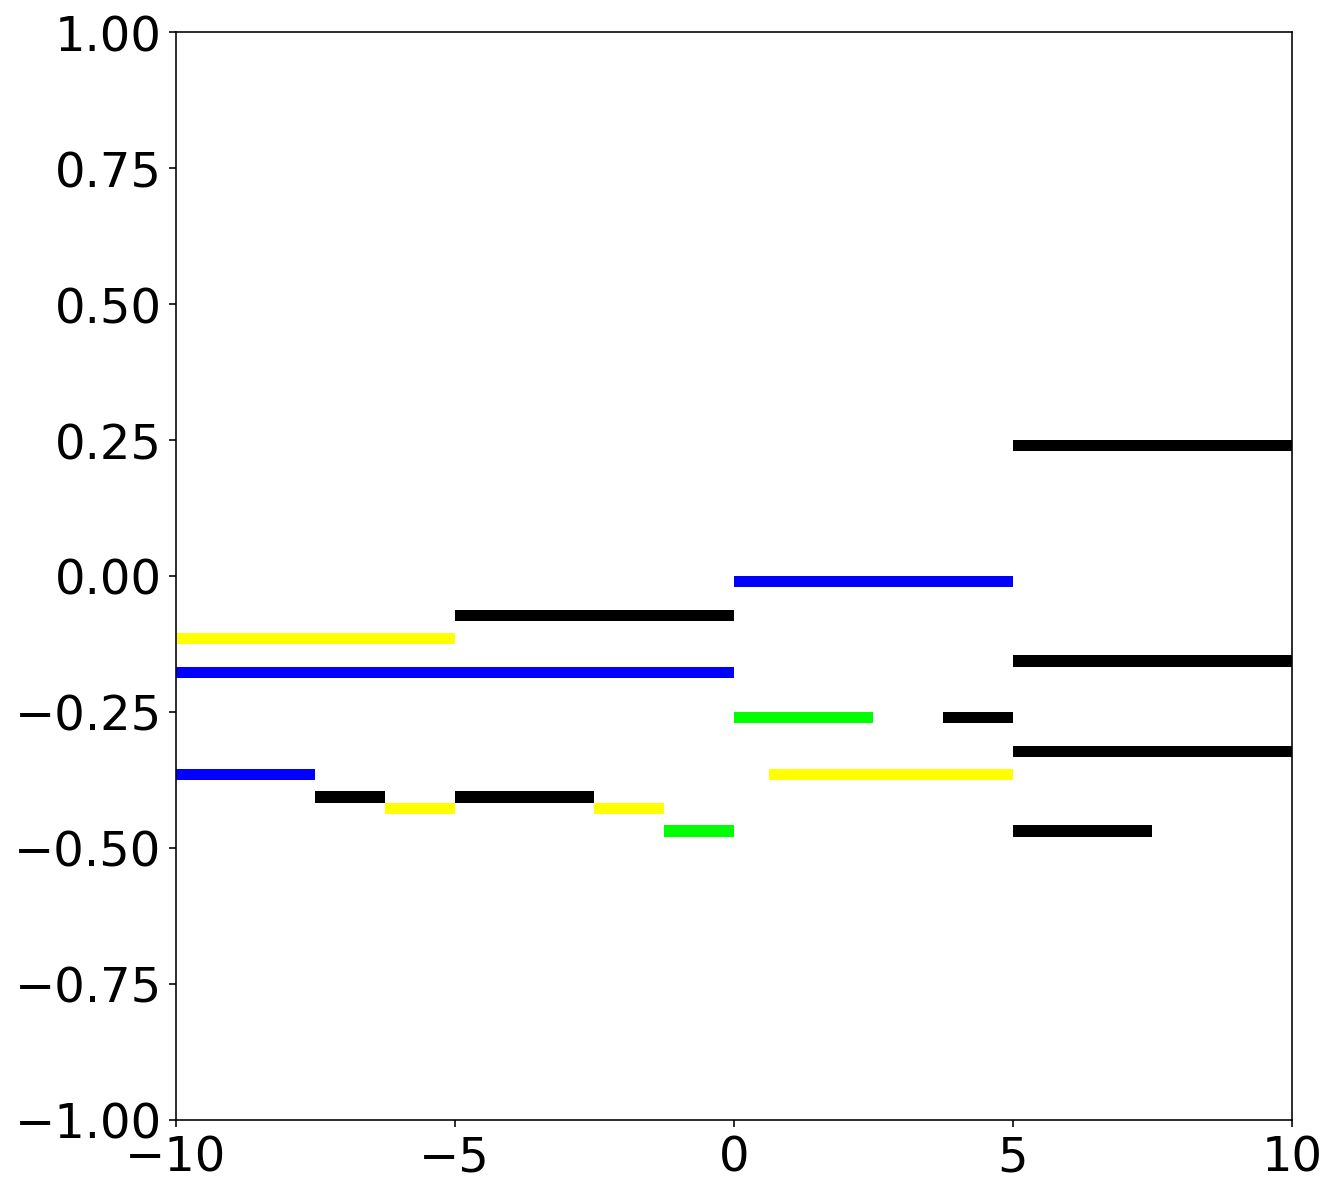

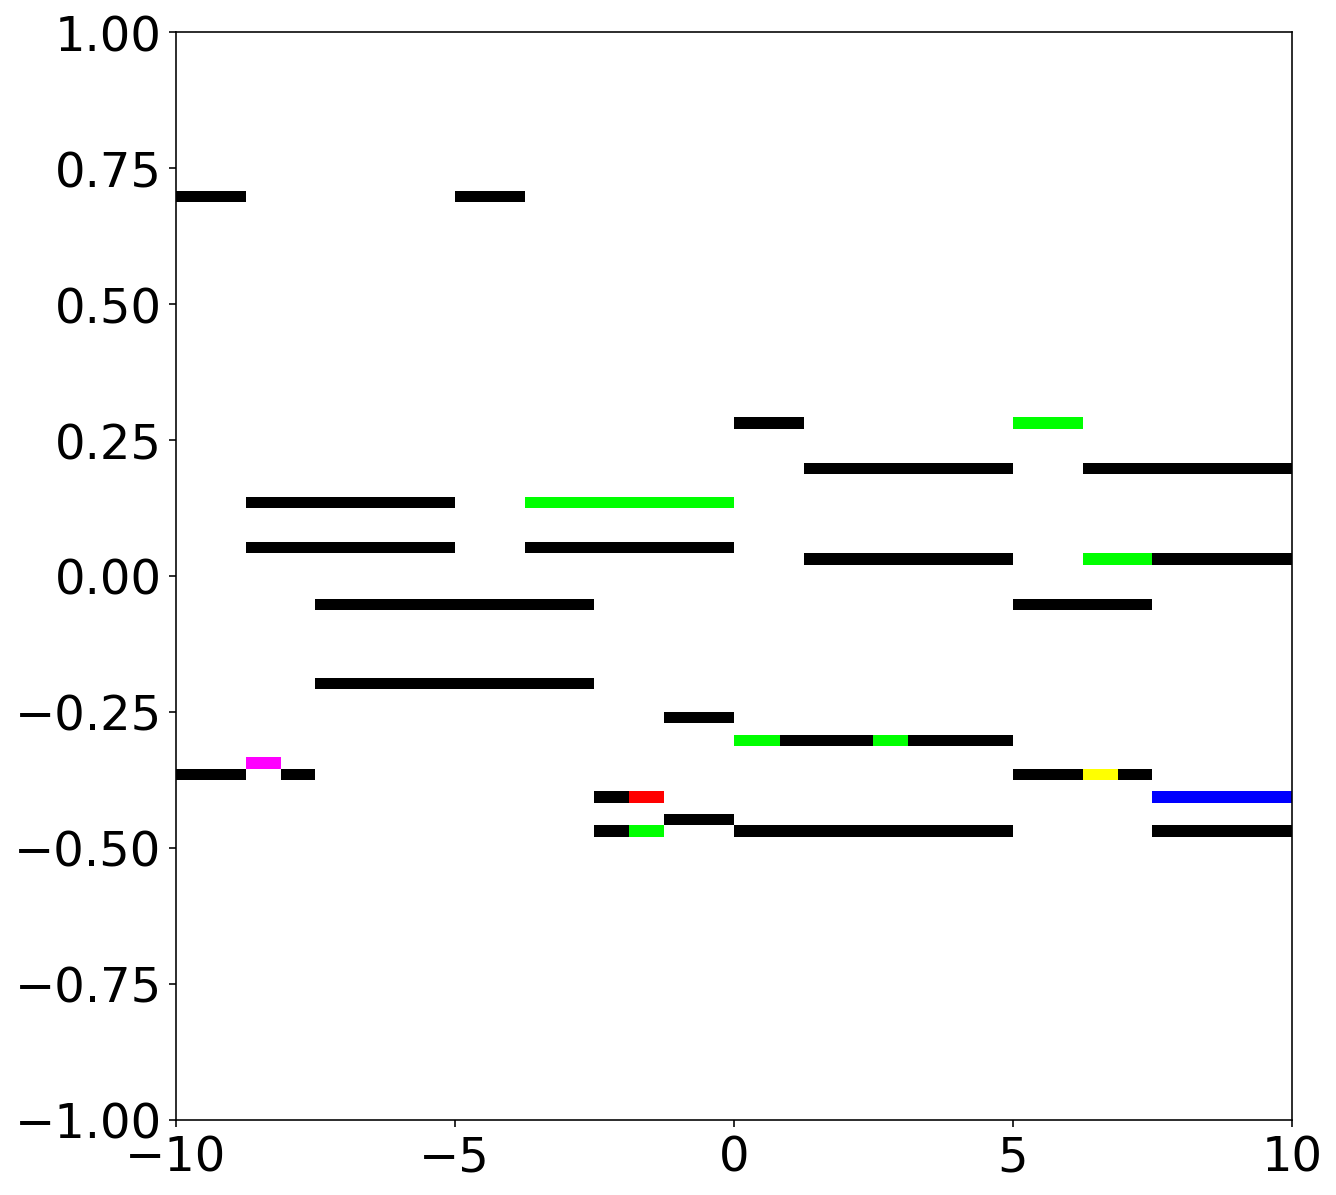

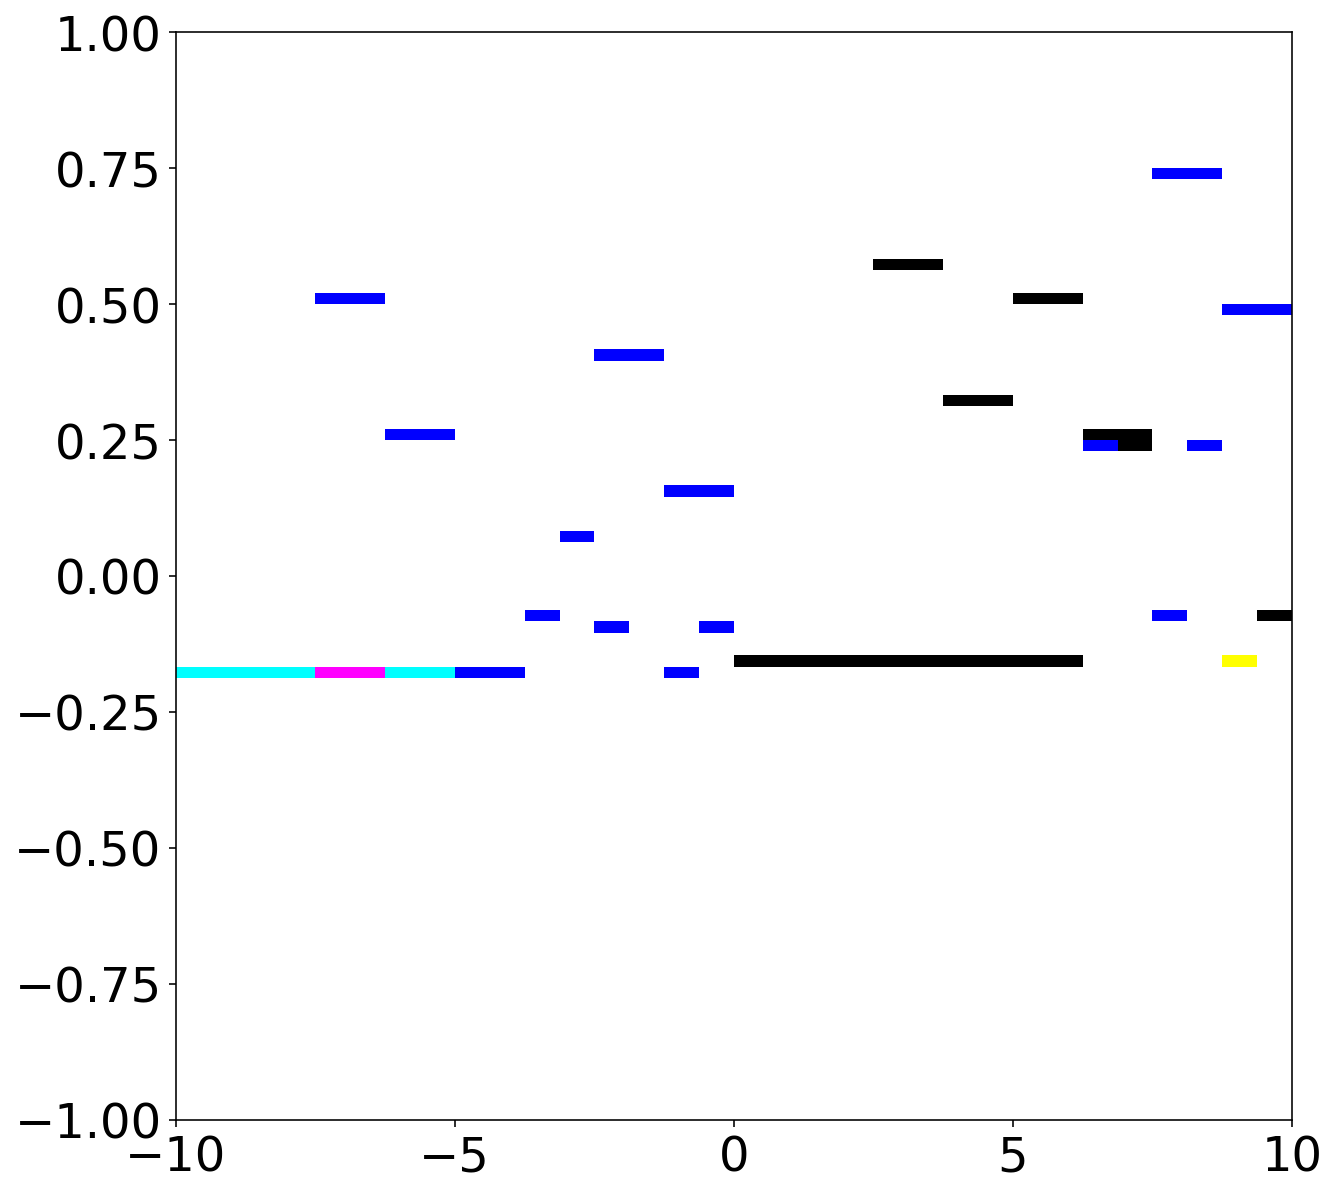

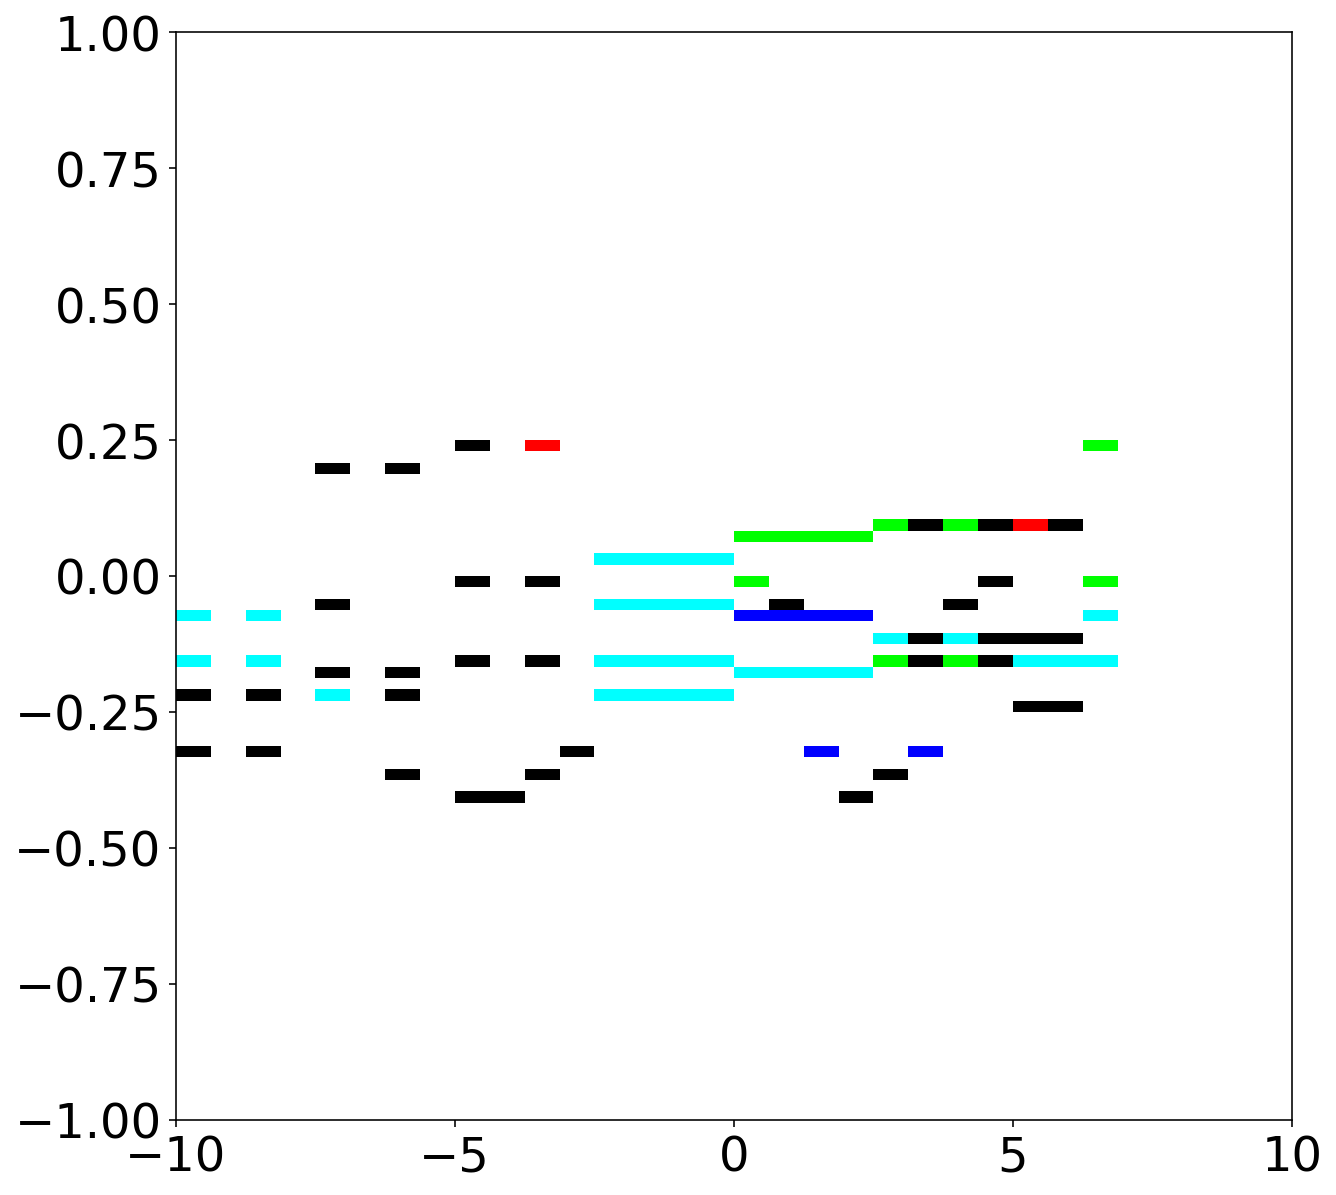

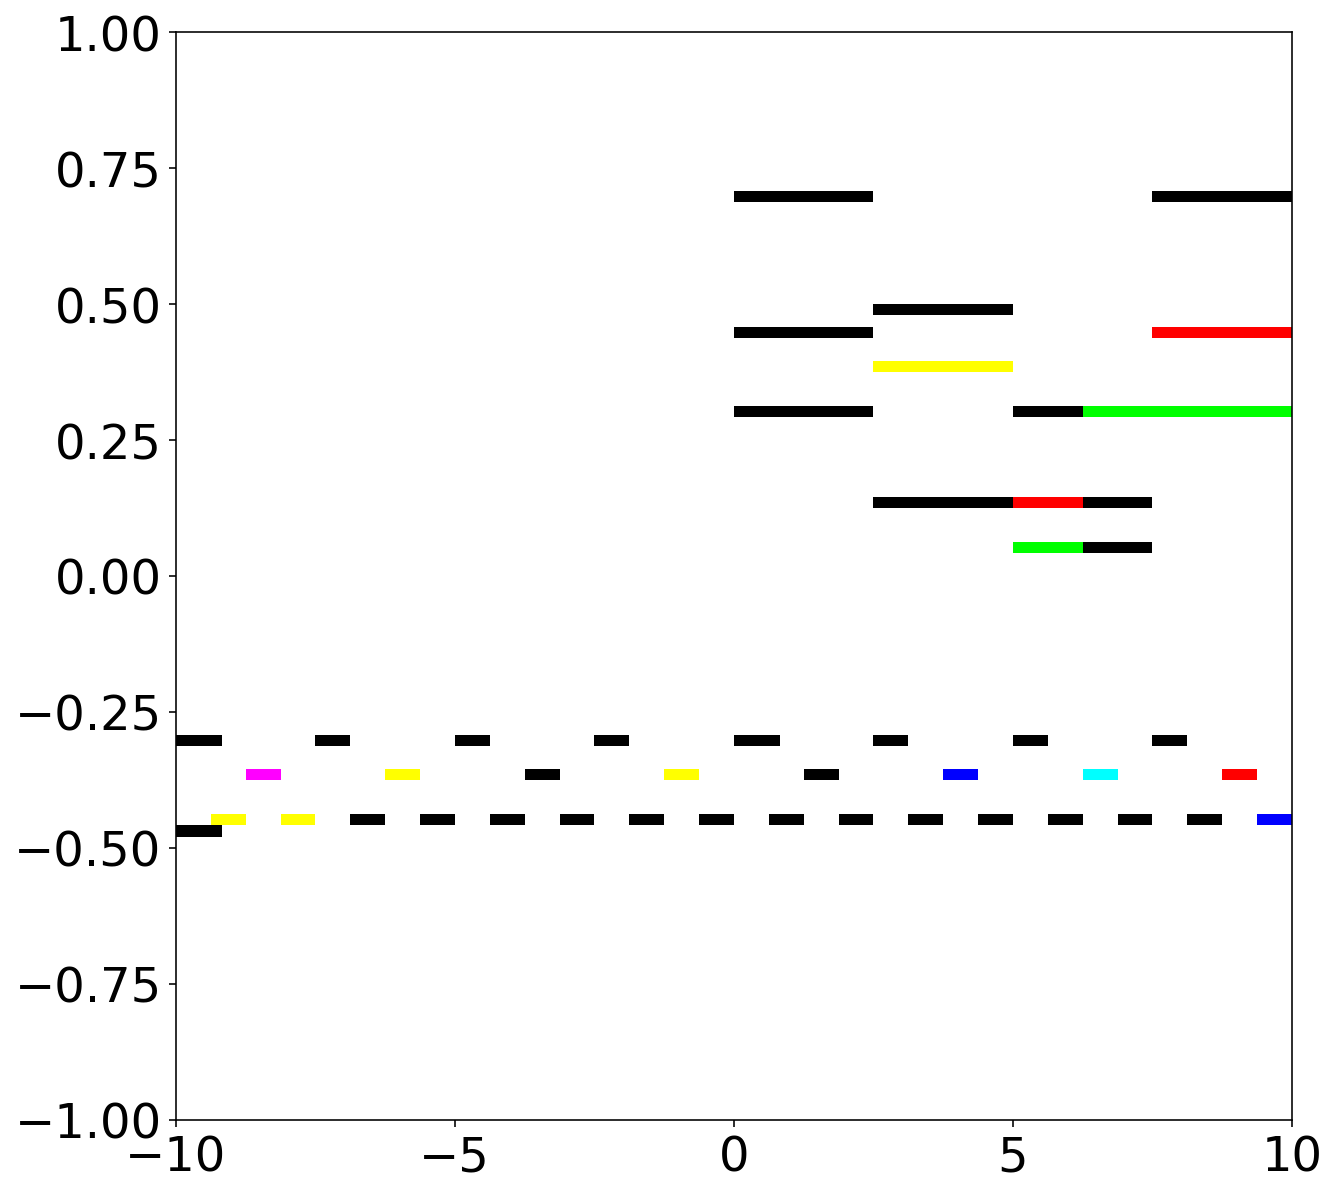

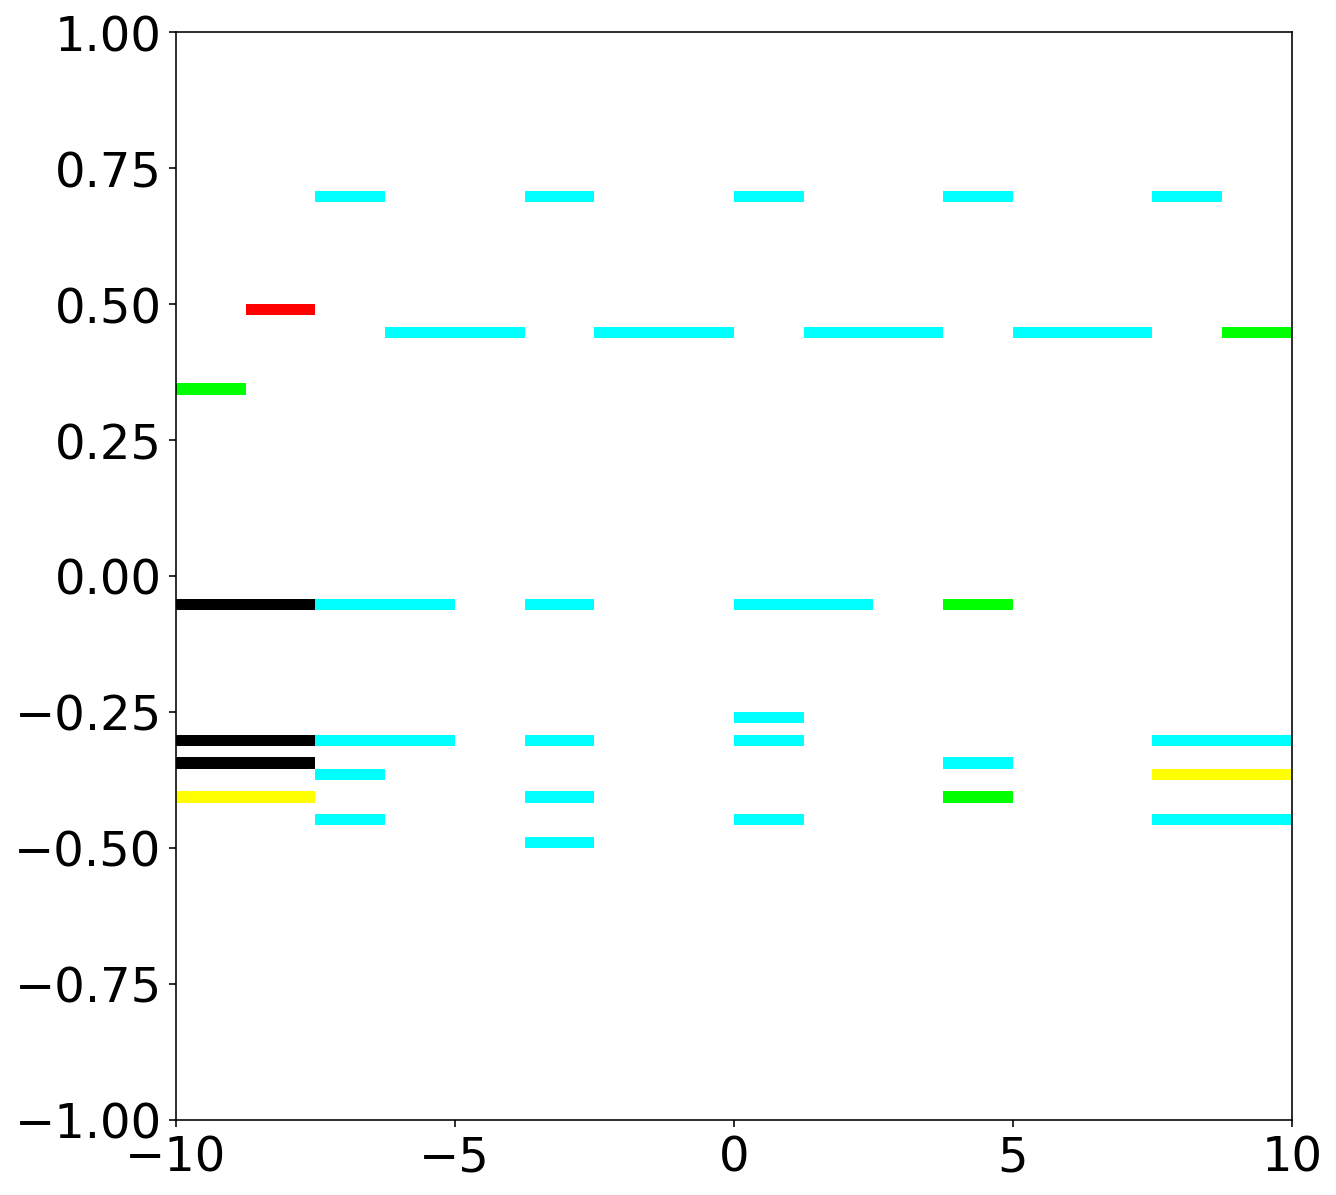

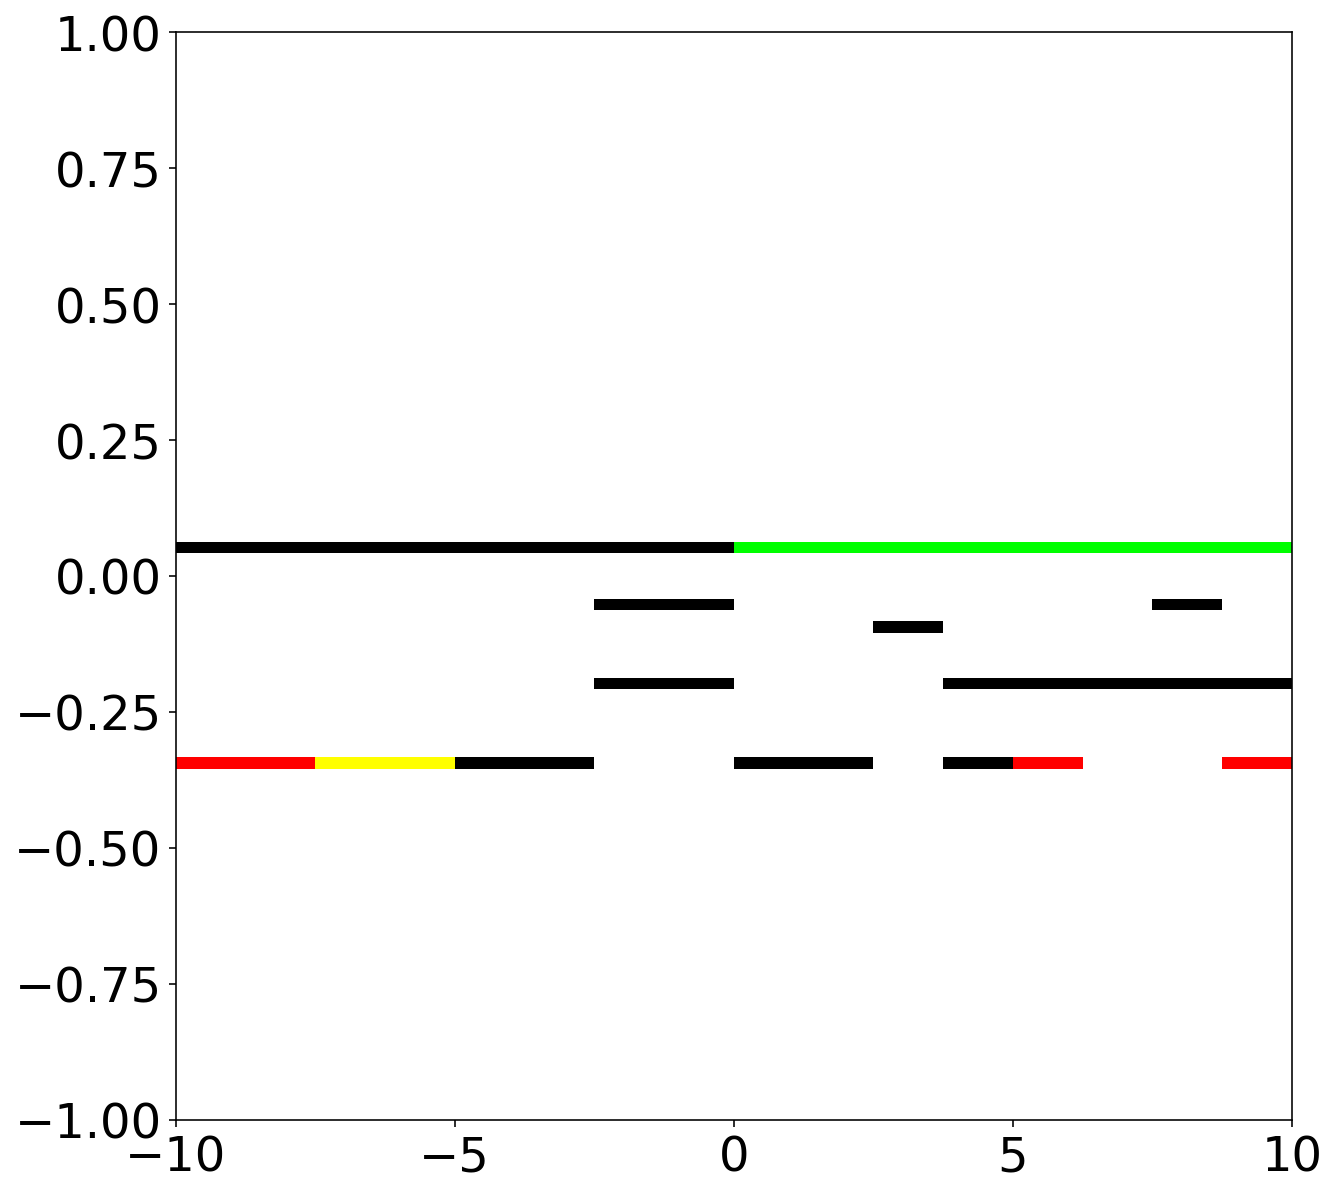

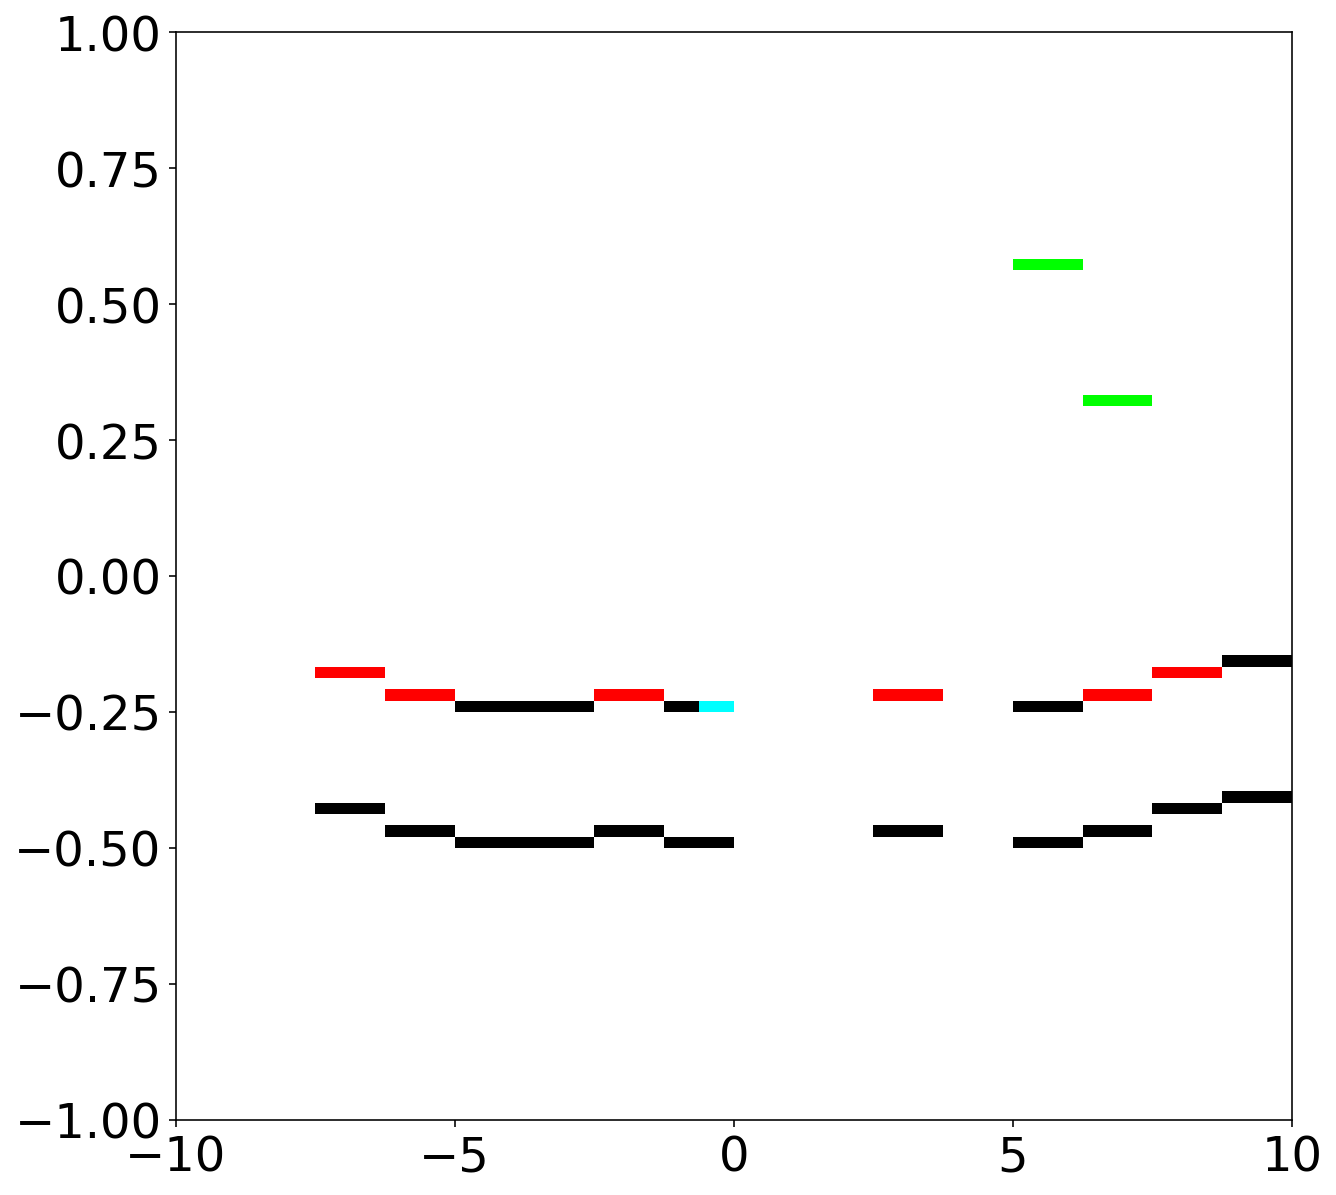

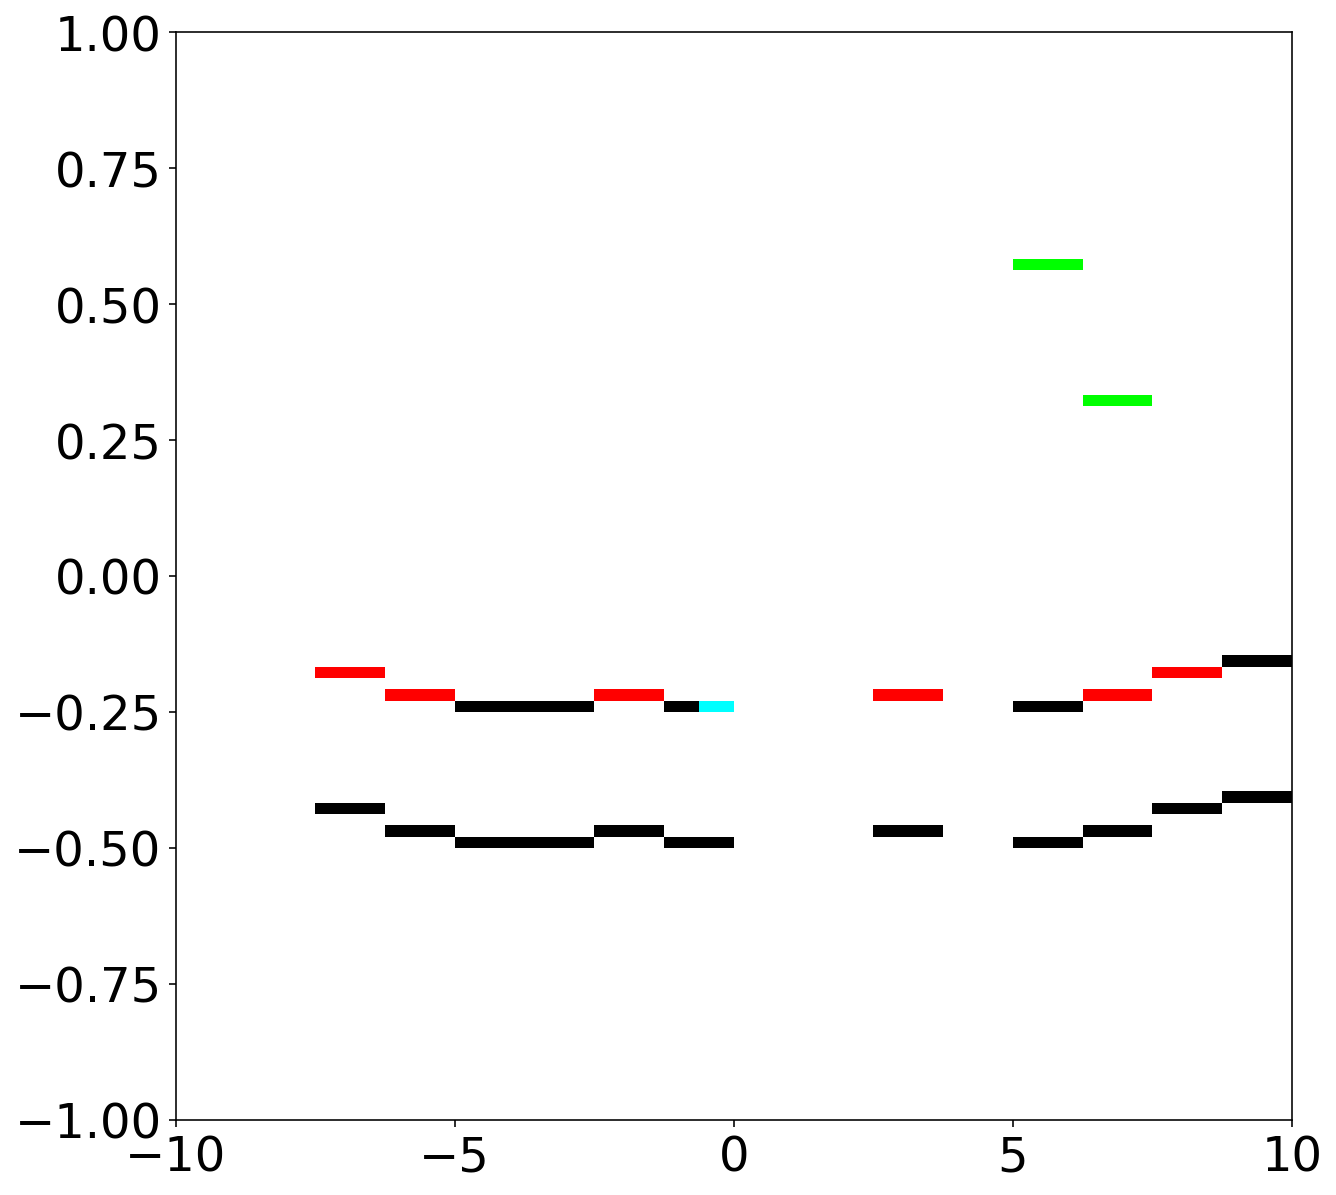

In [41]:
# Now let's pretend our channels are RGBA values and make a colored image

idx_all=np.arange(samples)
num_plot=10
for i in range(num_plot):
    
    idx=np.random.choice(idx_all,size=1)
    
    plt.imshow(ins[idx,:,:,:].reshape(image_height,image_width,num_channels),extent=[-10,10,-1,1],aspect='auto')
    #plt.axis('off')
    plt.show()

In [42]:
fp=open("ins_convgan_final_fantasy.pkl",'wb')
pickle.dump(ins,fp)
fp.close()

In [43]:
ins.shape

(4734, 96, 96, 4)